In [16]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from numpy import set_printoptions
set_printoptions(precision=3)
import pandas as pd
from pandas import DataFrame as df
from collections import Counter
from scipy import sparse # stack sparse features 
from pickle import dump,load
from operator import itemgetter
import csv

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from pyearth import Earth

from sklearn.preprocessing import Imputer,LabelEncoder,OneHotEncoder,StandardScaler,FunctionTransformer
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,ShuffleSplit,StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectFromModel,SelectKBest,chi2,RFE,mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix,classification_report,make_scorer,fbeta_score,roc_auc_score
from sklearn.pipeline import Pipeline

import greedy_feature_selection as gfs

In [2]:
# load data
train_data=pd.read_csv('../porto-seguro-data/train.csv')
test_data=pd.read_csv('../porto-seguro-data/test.csv') 

# data shape
print('Train Shape: {}'.format(train_data.shape))
print('Test Shape: {}'.format(test_data.shape))

Train Shape: (595212, 59)
Test Shape: (892816, 58)


In [3]:
# split data into X and y
y=df(train_data['target'],columns=['target'])
X=train_data.drop(['target','id'],axis=1)
test_id=test_data['id']
X_test=test_data.drop(['id'],axis=1)

In [12]:
# set global parameter value
n_jobs=-1
random_state=777
seed=222
test_size=0.2
scoring='roc_auc'
eval_metric='auc'
label_ratio=float(np.sum(y==0))/float(np.sum(y==1))

In [5]:
# instantiate general classes
rus=RandomUnderSampler(random_state=random_state)
lr=LogisticRegression(random_state=random_state)

In [6]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.1,stratify=y,random_state=random_state)

print('Train Shape: {}'.format(X_train.shape))
print('Hold-out Shape: {}'.format(X_val.shape))

Train Shape: (535690, 57)
Hold-out Shape: (59522, 57)


### Spot-Check with XGBoost
* API: http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.training
* params: https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

In [117]:
import xgboost as xgb

params={}
params['objective']='binary:logistic'
params['silent']=0
params['max_depth']=6
params['eta']=0.01
params['subsample']=0.8
params['colsample_bytree']=0.8
params['eval_metric']='auc'

dtrain=xgb.DMatrix(X_train,y_train)
dholdout=xgb.DMatrix(X_val,y_val)
num_boost_round=1000
#feval=gm.gini_xgb
#maximize=True
early_stopping_rounds=0.1*num_boost_round
as_pandas=True
verbose_eval=True
shuffle=True
evals=[(dtrain,'train'),(dholdout,'val')]
evals_result={}

base_model=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_boost_round,evals=evals,
              early_stopping_rounds=early_stopping_rounds,evals_result=evals_result,verbose_eval=verbose_eval)

[0]	train-auc:0.601924	val-auc:0.597093
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100.0 rounds.
[1]	train-auc:0.613789	val-auc:0.607245
[2]	train-auc:0.621529	val-auc:0.613164
[3]	train-auc:0.623478	val-auc:0.615976
[4]	train-auc:0.625735	val-auc:0.61967
[5]	train-auc:0.626941	val-auc:0.621153
[6]	train-auc:0.626539	val-auc:0.620934
[7]	train-auc:0.626415	val-auc:0.620787
[8]	train-auc:0.628025	val-auc:0.622204
[9]	train-auc:0.628752	val-auc:0.622085
[10]	train-auc:0.628723	val-auc:0.621932
[11]	train-auc:0.628826	val-auc:0.622329
[12]	train-auc:0.629071	val-auc:0.622385
[13]	train-auc:0.629058	val-auc:0.622584
[14]	train-auc:0.629055	val-auc:0.622428
[15]	train-auc:0.629334	val-auc:0.62284
[16]	train-auc:0.629	val-auc:0.622956
[17]	train-auc:0.628947	val-auc:0.622887
[18]	train-auc:0.629429	val-auc:0.622775
[19]	train-auc:0.629739	val-auc:0.623
[20]	train-auc:0.629719	val-auc:0.62295
[21]	train-auc:0

[196]	train-auc:0.643028	val-auc:0.630339
[197]	train-auc:0.643113	val-auc:0.63038
[198]	train-auc:0.643209	val-auc:0.630416
[199]	train-auc:0.643256	val-auc:0.630452
[200]	train-auc:0.643314	val-auc:0.630469
[201]	train-auc:0.643422	val-auc:0.630477
[202]	train-auc:0.64341	val-auc:0.630461
[203]	train-auc:0.643503	val-auc:0.630464
[204]	train-auc:0.643574	val-auc:0.630411
[205]	train-auc:0.643529	val-auc:0.630367
[206]	train-auc:0.643585	val-auc:0.630399
[207]	train-auc:0.643659	val-auc:0.630392
[208]	train-auc:0.64383	val-auc:0.630463
[209]	train-auc:0.643967	val-auc:0.630555
[210]	train-auc:0.643988	val-auc:0.630544
[211]	train-auc:0.644049	val-auc:0.630551
[212]	train-auc:0.644117	val-auc:0.630584
[213]	train-auc:0.644197	val-auc:0.630567
[214]	train-auc:0.644273	val-auc:0.630552
[215]	train-auc:0.644336	val-auc:0.630625
[216]	train-auc:0.644453	val-auc:0.63061
[217]	train-auc:0.644544	val-auc:0.630678
[218]	train-auc:0.64455	val-auc:0.630704
[219]	train-auc:0.64468	val-auc:0.63081

[393]	train-auc:0.660452	val-auc:0.636793
[394]	train-auc:0.660544	val-auc:0.636787
[395]	train-auc:0.660672	val-auc:0.63688
[396]	train-auc:0.660702	val-auc:0.636908
[397]	train-auc:0.660767	val-auc:0.636892
[398]	train-auc:0.660889	val-auc:0.63693
[399]	train-auc:0.660955	val-auc:0.636953
[400]	train-auc:0.661086	val-auc:0.636991
[401]	train-auc:0.661182	val-auc:0.637047
[402]	train-auc:0.661286	val-auc:0.637131
[403]	train-auc:0.661332	val-auc:0.637149
[404]	train-auc:0.661436	val-auc:0.637236
[405]	train-auc:0.661492	val-auc:0.63727
[406]	train-auc:0.661619	val-auc:0.637275
[407]	train-auc:0.661715	val-auc:0.637251
[408]	train-auc:0.661801	val-auc:0.637344
[409]	train-auc:0.661886	val-auc:0.637384
[410]	train-auc:0.661986	val-auc:0.637486
[411]	train-auc:0.662061	val-auc:0.637457
[412]	train-auc:0.662237	val-auc:0.637505
[413]	train-auc:0.662377	val-auc:0.63756
[414]	train-auc:0.662518	val-auc:0.63762
[415]	train-auc:0.662587	val-auc:0.637583
[416]	train-auc:0.662694	val-auc:0.6376

[589]	train-auc:0.678504	val-auc:0.640743
[590]	train-auc:0.678587	val-auc:0.640703
[591]	train-auc:0.678658	val-auc:0.640736
[592]	train-auc:0.678777	val-auc:0.640767
[593]	train-auc:0.678854	val-auc:0.640804
[594]	train-auc:0.678948	val-auc:0.640802
[595]	train-auc:0.679037	val-auc:0.6408
[596]	train-auc:0.679103	val-auc:0.640791
[597]	train-auc:0.679235	val-auc:0.640806
[598]	train-auc:0.679324	val-auc:0.640805
[599]	train-auc:0.679415	val-auc:0.640837
[600]	train-auc:0.67953	val-auc:0.640837
[601]	train-auc:0.679601	val-auc:0.640824
[602]	train-auc:0.679684	val-auc:0.640822
[603]	train-auc:0.679745	val-auc:0.640838
[604]	train-auc:0.679847	val-auc:0.640843
[605]	train-auc:0.6799	val-auc:0.640862
[606]	train-auc:0.679965	val-auc:0.640854
[607]	train-auc:0.680074	val-auc:0.640864
[608]	train-auc:0.680175	val-auc:0.64085
[609]	train-auc:0.68026	val-auc:0.640847
[610]	train-auc:0.680332	val-auc:0.640858
[611]	train-auc:0.680389	val-auc:0.640849
[612]	train-auc:0.680471	val-auc:0.640861

[786]	train-auc:0.694449	val-auc:0.642539
[787]	train-auc:0.694487	val-auc:0.642538
[788]	train-auc:0.694545	val-auc:0.642546
[789]	train-auc:0.694601	val-auc:0.642557
[790]	train-auc:0.694672	val-auc:0.642555
[791]	train-auc:0.69474	val-auc:0.64256
[792]	train-auc:0.694805	val-auc:0.642588
[793]	train-auc:0.694877	val-auc:0.6426
[794]	train-auc:0.694913	val-auc:0.642608
[795]	train-auc:0.694997	val-auc:0.642623
[796]	train-auc:0.695064	val-auc:0.642651
[797]	train-auc:0.695125	val-auc:0.642678
[798]	train-auc:0.695187	val-auc:0.64269
[799]	train-auc:0.695253	val-auc:0.642684
[800]	train-auc:0.695332	val-auc:0.642704
[801]	train-auc:0.695401	val-auc:0.642694
[802]	train-auc:0.695453	val-auc:0.642705
[803]	train-auc:0.695526	val-auc:0.642707
[804]	train-auc:0.695619	val-auc:0.642692
[805]	train-auc:0.695699	val-auc:0.642713
[806]	train-auc:0.695716	val-auc:0.642716
[807]	train-auc:0.69576	val-auc:0.642693
[808]	train-auc:0.695839	val-auc:0.642688
[809]	train-auc:0.695917	val-auc:0.64269

### Feature Selection with XGBoost

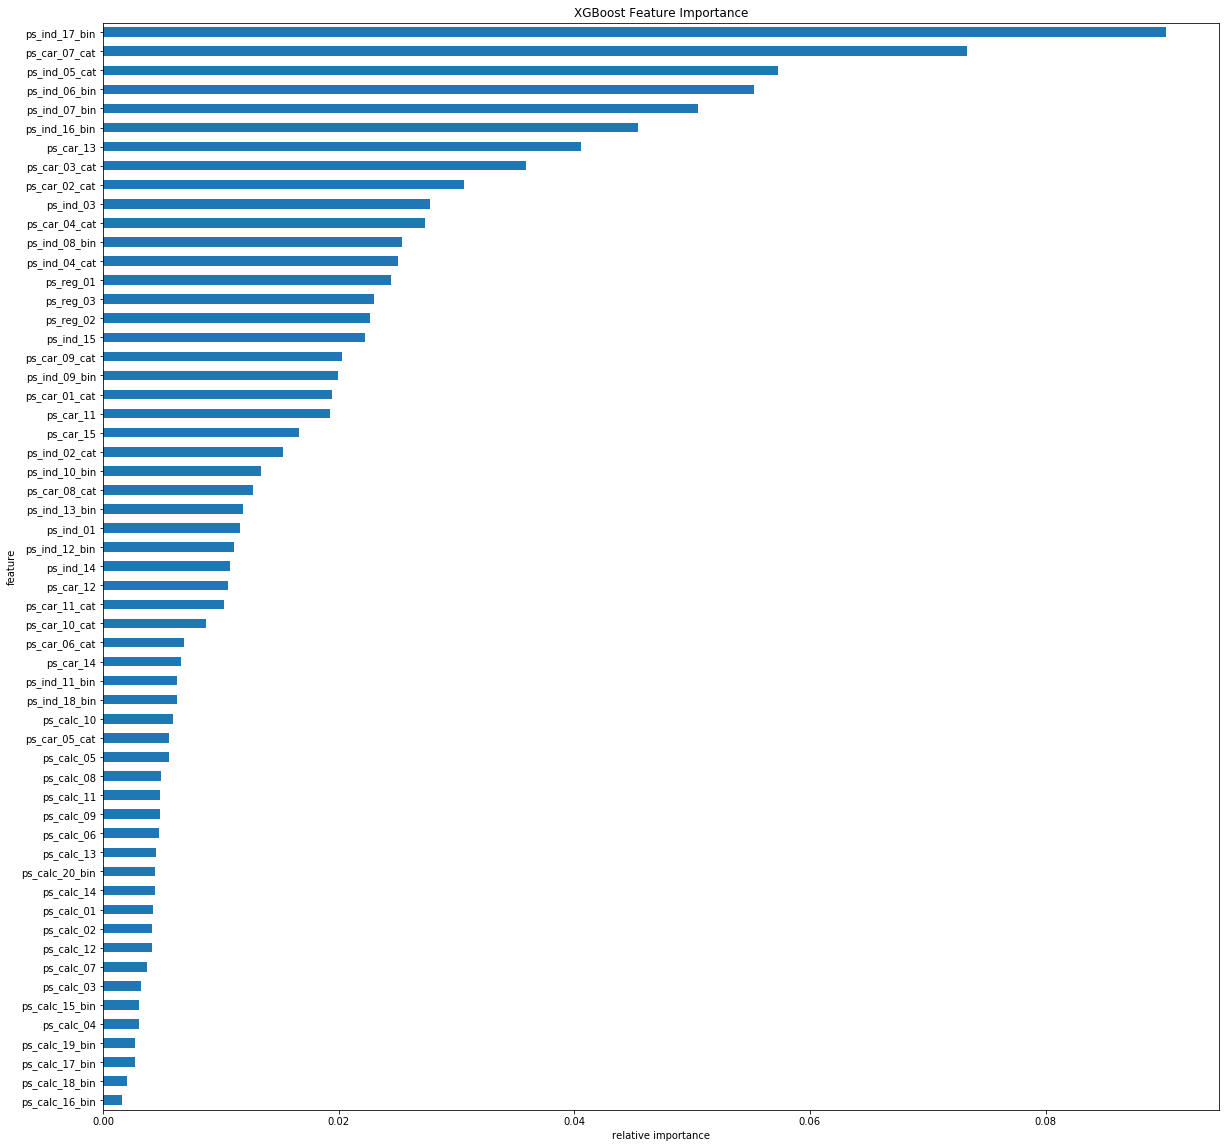

In [101]:
scores_dict=model_0.get_score(importance_type='cover')

scores_dict=sorted(scores_dict.items(),key=itemgetter(1),reverse=False)
scores_df=df(scores_dict,columns=['feature','score'])
scores_df['rel_score']=scores_df['score']/scores_df['score'].sum()

scores_df.plot(kind='barh',x='feature',y='rel_score',legend=False,figsize=(20,20))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance');

In [112]:
'''
0.645: type='gain',cutoff=0.015,feature_num=30;
0.645: type='cover',cutoff=0.011,feature_num=28;
''' 
feature_ind=scores_df[scores_df['rel_score']>0.011]['feature']
X_train_sel=X_train[feature_ind]
X_val_sel=X_val[feature_ind]

print(X_train_sel.shape)

(535690, 28)


In [111]:
import xgboost as xgb

params={}
params['objective']='binary:logistic'
params['silent']=0
params['max_depth']=6
params['eta']=0.01
params['subsample']=0.8
params['colsample_bytree']=0.8
params['eval_metric']='auc'

dtrain=xgb.DMatrix(X_train_sel,y_train)
dholdout=xgb.DMatrix(X_val_sel,y_val)
num_boost_round=1000
#feval=gm.gini_xgb
#maximize=True
early_stopping_rounds=0.1*num_boost_round
as_pandas=True
verbose_eval=True
shuffle=True
evals=[(dtrain,'train'),(dholdout,'val')]
evals_result={}

model=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_boost_round,evals=evals,
              early_stopping_rounds=early_stopping_rounds,evals_result=evals_result,verbose_eval=verbose_eval)

[0]	train-auc:0.610484	val-auc:0.609127
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100.0 rounds.
[1]	train-auc:0.617668	val-auc:0.615146
[2]	train-auc:0.621843	val-auc:0.618264
[3]	train-auc:0.623448	val-auc:0.618873
[4]	train-auc:0.623901	val-auc:0.618624
[5]	train-auc:0.624771	val-auc:0.618787
[6]	train-auc:0.627531	val-auc:0.622358
[7]	train-auc:0.627778	val-auc:0.622901
[8]	train-auc:0.628183	val-auc:0.623018
[9]	train-auc:0.627878	val-auc:0.622713
[10]	train-auc:0.627677	val-auc:0.622066
[11]	train-auc:0.628467	val-auc:0.622898
[12]	train-auc:0.628684	val-auc:0.623254
[13]	train-auc:0.629115	val-auc:0.623951
[14]	train-auc:0.629679	val-auc:0.624519
[15]	train-auc:0.630259	val-auc:0.625275
[16]	train-auc:0.630131	val-auc:0.624881
[17]	train-auc:0.630036	val-auc:0.624707
[18]	train-auc:0.630076	val-auc:0.62453
[19]	train-auc:0.630468	val-auc:0.624615
[20]	train-auc:0.63067	val-auc:0.624848
[21]	trai

[196]	train-auc:0.641345	val-auc:0.630596
[197]	train-auc:0.641518	val-auc:0.630753
[198]	train-auc:0.641668	val-auc:0.630697
[199]	train-auc:0.641736	val-auc:0.630748
[200]	train-auc:0.641841	val-auc:0.63078
[201]	train-auc:0.641868	val-auc:0.630819
[202]	train-auc:0.642014	val-auc:0.630841
[203]	train-auc:0.642023	val-auc:0.630747
[204]	train-auc:0.642235	val-auc:0.630844
[205]	train-auc:0.642273	val-auc:0.630917
[206]	train-auc:0.642311	val-auc:0.6309
[207]	train-auc:0.642351	val-auc:0.630936
[208]	train-auc:0.642409	val-auc:0.630922
[209]	train-auc:0.642526	val-auc:0.630912
[210]	train-auc:0.642604	val-auc:0.630917
[211]	train-auc:0.642662	val-auc:0.630948
[212]	train-auc:0.642779	val-auc:0.630998
[213]	train-auc:0.642819	val-auc:0.630987
[214]	train-auc:0.642826	val-auc:0.630962
[215]	train-auc:0.642895	val-auc:0.630966
[216]	train-auc:0.642904	val-auc:0.630973
[217]	train-auc:0.643011	val-auc:0.63104
[218]	train-auc:0.64305	val-auc:0.631078
[219]	train-auc:0.643087	val-auc:0.6311

[392]	train-auc:0.657127	val-auc:0.637245
[393]	train-auc:0.657255	val-auc:0.637264
[394]	train-auc:0.657322	val-auc:0.637269
[395]	train-auc:0.657391	val-auc:0.63734
[396]	train-auc:0.657488	val-auc:0.637329
[397]	train-auc:0.657508	val-auc:0.637299
[398]	train-auc:0.657558	val-auc:0.637318
[399]	train-auc:0.657689	val-auc:0.637336
[400]	train-auc:0.657736	val-auc:0.637351
[401]	train-auc:0.657775	val-auc:0.637357
[402]	train-auc:0.6579	val-auc:0.63742
[403]	train-auc:0.657969	val-auc:0.637422
[404]	train-auc:0.65804	val-auc:0.637455
[405]	train-auc:0.65814	val-auc:0.637468
[406]	train-auc:0.658201	val-auc:0.637513
[407]	train-auc:0.658304	val-auc:0.637608
[408]	train-auc:0.658388	val-auc:0.637627
[409]	train-auc:0.658447	val-auc:0.63762
[410]	train-auc:0.658491	val-auc:0.637627
[411]	train-auc:0.658596	val-auc:0.63767
[412]	train-auc:0.658671	val-auc:0.637699
[413]	train-auc:0.658788	val-auc:0.637784
[414]	train-auc:0.658857	val-auc:0.637783
[415]	train-auc:0.658952	val-auc:0.637802


[589]	train-auc:0.672445	val-auc:0.641561
[590]	train-auc:0.672514	val-auc:0.641606
[591]	train-auc:0.672613	val-auc:0.641614
[592]	train-auc:0.672681	val-auc:0.641636
[593]	train-auc:0.672745	val-auc:0.64162
[594]	train-auc:0.672801	val-auc:0.641622
[595]	train-auc:0.672871	val-auc:0.641646
[596]	train-auc:0.672938	val-auc:0.641642
[597]	train-auc:0.673022	val-auc:0.641628
[598]	train-auc:0.673099	val-auc:0.641626
[599]	train-auc:0.673126	val-auc:0.64163
[600]	train-auc:0.673179	val-auc:0.641632
[601]	train-auc:0.673232	val-auc:0.641643
[602]	train-auc:0.673291	val-auc:0.641649
[603]	train-auc:0.673357	val-auc:0.64166
[604]	train-auc:0.673427	val-auc:0.641664
[605]	train-auc:0.673454	val-auc:0.641673
[606]	train-auc:0.673562	val-auc:0.641677
[607]	train-auc:0.673645	val-auc:0.641732
[608]	train-auc:0.673705	val-auc:0.641733
[609]	train-auc:0.673764	val-auc:0.641746
[610]	train-auc:0.673841	val-auc:0.641787
[611]	train-auc:0.673908	val-auc:0.641808
[612]	train-auc:0.673961	val-auc:0.64

[785]	train-auc:0.684979	val-auc:0.64355
[786]	train-auc:0.685017	val-auc:0.643565
[787]	train-auc:0.685073	val-auc:0.643602
[788]	train-auc:0.685143	val-auc:0.643626
[789]	train-auc:0.685184	val-auc:0.643647
[790]	train-auc:0.685265	val-auc:0.643643
[791]	train-auc:0.685328	val-auc:0.643654
[792]	train-auc:0.685376	val-auc:0.643681
[793]	train-auc:0.685435	val-auc:0.643702
[794]	train-auc:0.6855	val-auc:0.64372
[795]	train-auc:0.685571	val-auc:0.643742
[796]	train-auc:0.685603	val-auc:0.643773
[797]	train-auc:0.685643	val-auc:0.643761
[798]	train-auc:0.685727	val-auc:0.643797
[799]	train-auc:0.685755	val-auc:0.643795
[800]	train-auc:0.68577	val-auc:0.643798
[801]	train-auc:0.685818	val-auc:0.643795
[802]	train-auc:0.685875	val-auc:0.643782
[803]	train-auc:0.685915	val-auc:0.643782
[804]	train-auc:0.685974	val-auc:0.643781
[805]	train-auc:0.686016	val-auc:0.64379
[806]	train-auc:0.686043	val-auc:0.643784
[807]	train-auc:0.686083	val-auc:0.643816
[808]	train-auc:0.686115	val-auc:0.64384

[982]	train-auc:0.694903	val-auc:0.64439
[983]	train-auc:0.694986	val-auc:0.644364
[984]	train-auc:0.695028	val-auc:0.644362
[985]	train-auc:0.695062	val-auc:0.644378
[986]	train-auc:0.695101	val-auc:0.644393
[987]	train-auc:0.695161	val-auc:0.644402
[988]	train-auc:0.6952	val-auc:0.6444
[989]	train-auc:0.695216	val-auc:0.644398
[990]	train-auc:0.695244	val-auc:0.644407
[991]	train-auc:0.695277	val-auc:0.644411
[992]	train-auc:0.695352	val-auc:0.644411
[993]	train-auc:0.695372	val-auc:0.644418
[994]	train-auc:0.695408	val-auc:0.644436
[995]	train-auc:0.695467	val-auc:0.644424
[996]	train-auc:0.695476	val-auc:0.644424
[997]	train-auc:0.695555	val-auc:0.644415
[998]	train-auc:0.695595	val-auc:0.644427
[999]	train-auc:0.695647	val-auc:0.644459


### Spot-Chcek with Logistic Regression

In [113]:
X_train_rus,y_train_rus=rus.fit_sample(X_train_sel,y_train)
lr.fit(X_train_rus,y_train_rus)
predicted=lr.predict_proba(X_val_sel)[:,1]
score=roc_auc_score(y_val,predicted)
print(score)

0.626766718229


In [12]:
pipe=make_pipeline(rus,lr)
cv=StratifiedKFold(n_splits=3,random_state=random_state)
scores=cross_val_score(pipe,X,y,scoring=scoring,cv=cv,n_jobs=n_jobs)
print(scores.mean())

0.622158805131


In [13]:
lr.fit(X_train,y_train)
predicted=lr.predict_proba(X_val)[:,1]
score=roc_auc_score(y_val,predicted)
print(score)

0.625257377176


### Split Features by Data Type - Binary, Categorical, Ordinal and Interval

In [7]:
# column names split by Binary, Categorical, Ordinal vs. Continuous
bin_col=[col for col in X_train.columns if '_bin' in col]
cat_col=[col for col in X_train.columns if '_cat' in col]
numer_col=[col for col in X_train.columns if '_cat' not in col and '_bin' not in col]
ord_col=X[numer_col].select_dtypes(include=['int64']).columns
cont_col=X[numer_col].select_dtypes(include=['float64']).columns

# dataframes by Binary, Categorical, Ordinal vs. Continuous
def split_data(df):
    df_cat=df[cat_col]
    df_bin=df[bin_col]
    df_ord=df[ord_col]
    df_cont=df[cont_col]
    return df_cat,df_bin,df_ord,df_cont

In [8]:
X_train_cat,X_train_bin,X_train_ord,X_train_cont=split_data(X_train)
X_val_cat,X_val_bin,X_val_ord,X_val_cont=split_data(X_val)
X_test_cat,X_test_bin,X_test_ord,X_test_cont=split_data(X_test)

print(X_train_cat.shape)
print(X_train_bin.shape)
print(X_train_ord.shape)
print(X_train_cont.shape)

(535690, 14)
(535690, 17)
(535690, 16)
(535690, 10)


### Encode Categorical Features - LabelEncoder and OneHotEncoder

In [9]:
# one hot encoding pipeline
def one_hot_encode(base_df,df):
    df_copy=df.copy()
    unique_list={col:list(base_df[col].unique()) for col in base_df.columns}
    for col in unique_list:
        if len(unique_list[col])>2:
            for val in unique_list[col]:
                df_copy[col+'_'+str(val)]=(df[col].values==val).astype(np.int)
            df_copy=df_copy.drop(col,axis=1)
    return df_copy

# call one-hot encoding
X_train_ohe=one_hot_encode(X_train_cat,X_train_cat)
X_val_ohe=one_hot_encode(X_train_cat,X_val_cat)
X_test_ohe=one_hot_encode(X_train_cat,X_test_cat)

print(X_train_ohe.shape)

(535690, 183)


### Spot-Check with XGBoost

In [135]:
X_train_stacked=pd.concat([X_train_ohe,X_train_bin,X_train_ord,X_train_cont],axis=1)
X_val_stacked=pd.concat([X_val_ohe,X_val_bin,X_val_ord,X_val_cont],axis=1)
X_test_stacked=pd.concat([X_test_ohe,X_test_bin,X_test_ord,X_test_cont],axis=1)

print(X_train_stacked.shape)

(535690, 226)


In [141]:
import xgboost as xgb

params={}
params['objective']='binary:logistic'
params['silent']=0
params['max_depth']=6
params['eta']=0.01
params['subsample']=0.8
params['colsample_bytree']=0.8
params['eval_metric']='auc'

dtrain=xgb.DMatrix(X_train_stacked,y_train)
dholdout=xgb.DMatrix(X_val_stacked,y_val)
num_boost_round=1000
#feval=gm.gini_xgb
#maximize=True
early_stopping_rounds=0.1*num_boost_round
as_pandas=True
verbose_eval=True
shuffle=True
evals=[(dtrain,'train'),(dholdout,'val')]
evals_result={}

base_model=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_boost_round,evals=evals,
              early_stopping_rounds=early_stopping_rounds,evals_result=evals_result,verbose_eval=verbose_eval)

[0]	train-auc:0.607326	val-auc:0.603103
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100.0 rounds.
[1]	train-auc:0.619822	val-auc:0.615849
[2]	train-auc:0.623064	val-auc:0.617439
[3]	train-auc:0.624859	val-auc:0.618925
[4]	train-auc:0.625774	val-auc:0.619323
[5]	train-auc:0.625879	val-auc:0.619554
[6]	train-auc:0.627295	val-auc:0.620946
[7]	train-auc:0.627766	val-auc:0.620898
[8]	train-auc:0.627649	val-auc:0.620131
[9]	train-auc:0.628572	val-auc:0.621198
[10]	train-auc:0.628772	val-auc:0.621331
[11]	train-auc:0.628684	val-auc:0.621788
[12]	train-auc:0.628994	val-auc:0.621855
[13]	train-auc:0.629067	val-auc:0.621972
[14]	train-auc:0.62962	val-auc:0.622591
[15]	train-auc:0.62983	val-auc:0.622813
[16]	train-auc:0.629824	val-auc:0.622817
[17]	train-auc:0.630385	val-auc:0.623264
[18]	train-auc:0.630518	val-auc:0.623387
[19]	train-auc:0.630834	val-auc:0.623667
[20]	train-auc:0.630709	val-auc:0.623513
[21]	trai

[196]	train-auc:0.643504	val-auc:0.629367
[197]	train-auc:0.643648	val-auc:0.629453
[198]	train-auc:0.64367	val-auc:0.62946
[199]	train-auc:0.643722	val-auc:0.629475
[200]	train-auc:0.643719	val-auc:0.629436
[201]	train-auc:0.643742	val-auc:0.629435
[202]	train-auc:0.643761	val-auc:0.629432
[203]	train-auc:0.643846	val-auc:0.629508
[204]	train-auc:0.643928	val-auc:0.629486
[205]	train-auc:0.643917	val-auc:0.629425
[206]	train-auc:0.643993	val-auc:0.629359
[207]	train-auc:0.644053	val-auc:0.62942
[208]	train-auc:0.64421	val-auc:0.629481
[209]	train-auc:0.644243	val-auc:0.629515
[210]	train-auc:0.644314	val-auc:0.629544
[211]	train-auc:0.644402	val-auc:0.629555
[212]	train-auc:0.644466	val-auc:0.629552
[213]	train-auc:0.64448	val-auc:0.62953
[214]	train-auc:0.644566	val-auc:0.62958
[215]	train-auc:0.64461	val-auc:0.629631
[216]	train-auc:0.644676	val-auc:0.629685
[217]	train-auc:0.644706	val-auc:0.62972
[218]	train-auc:0.644717	val-auc:0.629679
[219]	train-auc:0.644771	val-auc:0.629751
[

[393]	train-auc:0.662208	val-auc:0.636747
[394]	train-auc:0.662276	val-auc:0.636745
[395]	train-auc:0.662396	val-auc:0.636773
[396]	train-auc:0.66252	val-auc:0.636809
[397]	train-auc:0.6626	val-auc:0.636805
[398]	train-auc:0.662709	val-auc:0.636882
[399]	train-auc:0.66281	val-auc:0.636896
[400]	train-auc:0.662918	val-auc:0.636943
[401]	train-auc:0.663063	val-auc:0.636959
[402]	train-auc:0.663125	val-auc:0.636927
[403]	train-auc:0.663186	val-auc:0.63699
[404]	train-auc:0.663264	val-auc:0.636975
[405]	train-auc:0.66334	val-auc:0.63701
[406]	train-auc:0.663447	val-auc:0.63706
[407]	train-auc:0.663547	val-auc:0.637133
[408]	train-auc:0.66361	val-auc:0.637161
[409]	train-auc:0.663728	val-auc:0.637186
[410]	train-auc:0.663833	val-auc:0.637205
[411]	train-auc:0.663973	val-auc:0.637292
[412]	train-auc:0.664018	val-auc:0.637319
[413]	train-auc:0.664135	val-auc:0.637392
[414]	train-auc:0.664237	val-auc:0.637419
[415]	train-auc:0.664301	val-auc:0.63748
[416]	train-auc:0.664385	val-auc:0.637507
[4

[590]	train-auc:0.679702	val-auc:0.641356
[591]	train-auc:0.679808	val-auc:0.641393
[592]	train-auc:0.679914	val-auc:0.641399
[593]	train-auc:0.679979	val-auc:0.641417
[594]	train-auc:0.680054	val-auc:0.641426
[595]	train-auc:0.680138	val-auc:0.64142
[596]	train-auc:0.680214	val-auc:0.641449
[597]	train-auc:0.680307	val-auc:0.641447
[598]	train-auc:0.680391	val-auc:0.641475
[599]	train-auc:0.680502	val-auc:0.64148
[600]	train-auc:0.680563	val-auc:0.641534
[601]	train-auc:0.680628	val-auc:0.64154
[602]	train-auc:0.680683	val-auc:0.641527
[603]	train-auc:0.680759	val-auc:0.641524
[604]	train-auc:0.680812	val-auc:0.641497
[605]	train-auc:0.680869	val-auc:0.641474
[606]	train-auc:0.680997	val-auc:0.64148
[607]	train-auc:0.681059	val-auc:0.641492
[608]	train-auc:0.681183	val-auc:0.641509
[609]	train-auc:0.681204	val-auc:0.641487
[610]	train-auc:0.681238	val-auc:0.64149
[611]	train-auc:0.681342	val-auc:0.641502
[612]	train-auc:0.681418	val-auc:0.641478
[613]	train-auc:0.681538	val-auc:0.6414

[787]	train-auc:0.693414	val-auc:0.642753
[788]	train-auc:0.693447	val-auc:0.642771
[789]	train-auc:0.693496	val-auc:0.642766
[790]	train-auc:0.693558	val-auc:0.642755
[791]	train-auc:0.693595	val-auc:0.642741
[792]	train-auc:0.693662	val-auc:0.642745
[793]	train-auc:0.693701	val-auc:0.642742
[794]	train-auc:0.693786	val-auc:0.642748
[795]	train-auc:0.69383	val-auc:0.642758
[796]	train-auc:0.693924	val-auc:0.642757
[797]	train-auc:0.694007	val-auc:0.642757
[798]	train-auc:0.694072	val-auc:0.642751
[799]	train-auc:0.694133	val-auc:0.642786
[800]	train-auc:0.694176	val-auc:0.642802
[801]	train-auc:0.694228	val-auc:0.6428
[802]	train-auc:0.694344	val-auc:0.642811
[803]	train-auc:0.694377	val-auc:0.642813
[804]	train-auc:0.694461	val-auc:0.642829
[805]	train-auc:0.694573	val-auc:0.642859
[806]	train-auc:0.694646	val-auc:0.642878
[807]	train-auc:0.69469	val-auc:0.642887
[808]	train-auc:0.694758	val-auc:0.642909
[809]	train-auc:0.694817	val-auc:0.642926
[810]	train-auc:0.694896	val-auc:0.642

[983]	train-auc:0.705689	val-auc:0.643743
[984]	train-auc:0.705714	val-auc:0.643733
[985]	train-auc:0.70579	val-auc:0.643749
[986]	train-auc:0.705817	val-auc:0.64373
[987]	train-auc:0.705866	val-auc:0.643738
[988]	train-auc:0.705933	val-auc:0.64374
[989]	train-auc:0.706012	val-auc:0.643735
[990]	train-auc:0.706045	val-auc:0.643773
[991]	train-auc:0.706092	val-auc:0.643783
[992]	train-auc:0.706178	val-auc:0.643775
[993]	train-auc:0.706279	val-auc:0.643796
[994]	train-auc:0.706312	val-auc:0.643802
[995]	train-auc:0.706361	val-auc:0.643805
[996]	train-auc:0.706437	val-auc:0.643825
[997]	train-auc:0.706509	val-auc:0.643794
[998]	train-auc:0.706575	val-auc:0.643773
[999]	train-auc:0.706663	val-auc:0.643783


### Feature Selection with XGBoost

In [158]:
scores_dict=base_model.get_score(importance_type='cover')

scores_dict=sorted(scores_dict.items(),key=itemgetter(1),reverse=False)
scores_df=df(scores_dict,columns=['feature','score'])
scores_df['rel_score']=scores_df['score']/scores_df['score'].sum()

feature_ind=scores_df[scores_df['rel_score']>0.0025]['feature']
X_train_sel=X_train_stacked[feature_ind]
X_val_sel=X_val_stacked[feature_ind]

print(X_train_sel.shape)

(535690, 121)


In [157]:
import xgboost as xgb
from xgboost import XGBClassifier

params={}
params['objective']='binary:logistic'
params['silent']=0
params['max_depth']=6
params['eta']=0.01
params['subsample']=0.8
params['colsample_bytree']=0.8
params['eval_metric']='auc'

dtrain=xgb.DMatrix(X_train_sel,y_train)
dholdout=xgb.DMatrix(X_val_sel,y_val)
num_boost_round=1000
#feval=gm.gini_xgb
#maximize=True
early_stopping_rounds=0.1*num_boost_round
as_pandas=True
verbose_eval=True
shuffle=True
evals=[(dtrain,'train'),(dholdout,'val')]
evals_result={}

model=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_boost_round,evals=evals,
              early_stopping_rounds=early_stopping_rounds,evals_result=evals_result,verbose_eval=verbose_eval)

[0]	train-auc:0.611125	val-auc:0.607708
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100.0 rounds.
[1]	train-auc:0.614889	val-auc:0.61155
[2]	train-auc:0.619455	val-auc:0.614408
[3]	train-auc:0.620376	val-auc:0.615035
[4]	train-auc:0.621755	val-auc:0.616098
[5]	train-auc:0.623201	val-auc:0.617376
[6]	train-auc:0.624562	val-auc:0.619111
[7]	train-auc:0.625363	val-auc:0.619926
[8]	train-auc:0.62605	val-auc:0.620604
[9]	train-auc:0.626888	val-auc:0.621703
[10]	train-auc:0.627621	val-auc:0.621975
[11]	train-auc:0.628439	val-auc:0.622692
[12]	train-auc:0.628853	val-auc:0.62271
[13]	train-auc:0.62947	val-auc:0.622501
[14]	train-auc:0.629433	val-auc:0.622551
[15]	train-auc:0.629907	val-auc:0.62215
[16]	train-auc:0.630387	val-auc:0.62226
[17]	train-auc:0.630452	val-auc:0.622423
[18]	train-auc:0.630592	val-auc:0.622348
[19]	train-auc:0.630907	val-auc:0.62259
[20]	train-auc:0.630919	val-auc:0.622757
[21]	train-auc

[196]	train-auc:0.642616	val-auc:0.62934
[197]	train-auc:0.64267	val-auc:0.629392
[198]	train-auc:0.642651	val-auc:0.629345
[199]	train-auc:0.642645	val-auc:0.629372
[200]	train-auc:0.64276	val-auc:0.629466
[201]	train-auc:0.642774	val-auc:0.629459
[202]	train-auc:0.642786	val-auc:0.629464
[203]	train-auc:0.642826	val-auc:0.629488
[204]	train-auc:0.64289	val-auc:0.629482
[205]	train-auc:0.642976	val-auc:0.629535
[206]	train-auc:0.642964	val-auc:0.629536
[207]	train-auc:0.643031	val-auc:0.629595
[208]	train-auc:0.643063	val-auc:0.629573
[209]	train-auc:0.643203	val-auc:0.629602
[210]	train-auc:0.643254	val-auc:0.629661
[211]	train-auc:0.64326	val-auc:0.629703
[212]	train-auc:0.643239	val-auc:0.629733
[213]	train-auc:0.643319	val-auc:0.62975
[214]	train-auc:0.643497	val-auc:0.629801
[215]	train-auc:0.643514	val-auc:0.629768
[216]	train-auc:0.643662	val-auc:0.629864
[217]	train-auc:0.643691	val-auc:0.629882
[218]	train-auc:0.643761	val-auc:0.629932
[219]	train-auc:0.643826	val-auc:0.63000

[393]	train-auc:0.658466	val-auc:0.636508
[394]	train-auc:0.658551	val-auc:0.636563
[395]	train-auc:0.65864	val-auc:0.636625
[396]	train-auc:0.658734	val-auc:0.636676
[397]	train-auc:0.65882	val-auc:0.636697
[398]	train-auc:0.658886	val-auc:0.636776
[399]	train-auc:0.658967	val-auc:0.636873
[400]	train-auc:0.659016	val-auc:0.636901
[401]	train-auc:0.659107	val-auc:0.636941
[402]	train-auc:0.659192	val-auc:0.636943
[403]	train-auc:0.659314	val-auc:0.636995
[404]	train-auc:0.659384	val-auc:0.637021
[405]	train-auc:0.659437	val-auc:0.637055
[406]	train-auc:0.659565	val-auc:0.637138
[407]	train-auc:0.659702	val-auc:0.637187
[408]	train-auc:0.659737	val-auc:0.637157
[409]	train-auc:0.659836	val-auc:0.63718
[410]	train-auc:0.659881	val-auc:0.637189
[411]	train-auc:0.659974	val-auc:0.637218
[412]	train-auc:0.660054	val-auc:0.637229
[413]	train-auc:0.660153	val-auc:0.637206
[414]	train-auc:0.660244	val-auc:0.637279
[415]	train-auc:0.6603	val-auc:0.637265
[416]	train-auc:0.660425	val-auc:0.6373

[589]	train-auc:0.673583	val-auc:0.64134
[590]	train-auc:0.673646	val-auc:0.641319
[591]	train-auc:0.673725	val-auc:0.641376
[592]	train-auc:0.673786	val-auc:0.641423
[593]	train-auc:0.673848	val-auc:0.64143
[594]	train-auc:0.673965	val-auc:0.641489
[595]	train-auc:0.674037	val-auc:0.641551
[596]	train-auc:0.674093	val-auc:0.641562
[597]	train-auc:0.674162	val-auc:0.641569
[598]	train-auc:0.674209	val-auc:0.641607
[599]	train-auc:0.674265	val-auc:0.641624
[600]	train-auc:0.67435	val-auc:0.641678
[601]	train-auc:0.674369	val-auc:0.641681
[602]	train-auc:0.674462	val-auc:0.64172
[603]	train-auc:0.674515	val-auc:0.64179
[604]	train-auc:0.674571	val-auc:0.641795
[605]	train-auc:0.674635	val-auc:0.641806
[606]	train-auc:0.674664	val-auc:0.641811
[607]	train-auc:0.674718	val-auc:0.641831
[608]	train-auc:0.67476	val-auc:0.641846
[609]	train-auc:0.674819	val-auc:0.641872
[610]	train-auc:0.674858	val-auc:0.641887
[611]	train-auc:0.674905	val-auc:0.641904
[612]	train-auc:0.674968	val-auc:0.64191

[786]	train-auc:0.684728	val-auc:0.643919
[787]	train-auc:0.684782	val-auc:0.643945
[788]	train-auc:0.684787	val-auc:0.643947
[789]	train-auc:0.684856	val-auc:0.64395
[790]	train-auc:0.684914	val-auc:0.643931
[791]	train-auc:0.684972	val-auc:0.643923
[792]	train-auc:0.685013	val-auc:0.64392
[793]	train-auc:0.685093	val-auc:0.64391
[794]	train-auc:0.685127	val-auc:0.643904
[795]	train-auc:0.685161	val-auc:0.643926
[796]	train-auc:0.685214	val-auc:0.643948
[797]	train-auc:0.685296	val-auc:0.643971
[798]	train-auc:0.685333	val-auc:0.643964
[799]	train-auc:0.685369	val-auc:0.64398
[800]	train-auc:0.685413	val-auc:0.643991
[801]	train-auc:0.685468	val-auc:0.643983
[802]	train-auc:0.685521	val-auc:0.644005
[803]	train-auc:0.685548	val-auc:0.644012
[804]	train-auc:0.685599	val-auc:0.643996
[805]	train-auc:0.685661	val-auc:0.644031
[806]	train-auc:0.685715	val-auc:0.644033
[807]	train-auc:0.685774	val-auc:0.644036
[808]	train-auc:0.685799	val-auc:0.644054
[809]	train-auc:0.685854	val-auc:0.644

[983]	train-auc:0.693695	val-auc:0.644837
[984]	train-auc:0.693724	val-auc:0.644837
[985]	train-auc:0.693764	val-auc:0.644847
[986]	train-auc:0.69381	val-auc:0.644832
[987]	train-auc:0.693864	val-auc:0.644849
[988]	train-auc:0.693895	val-auc:0.644839
[989]	train-auc:0.693945	val-auc:0.644839
[990]	train-auc:0.693987	val-auc:0.644831
[991]	train-auc:0.69403	val-auc:0.644827
[992]	train-auc:0.694074	val-auc:0.644832
[993]	train-auc:0.694125	val-auc:0.644858
[994]	train-auc:0.694198	val-auc:0.644853
[995]	train-auc:0.69424	val-auc:0.644864
[996]	train-auc:0.694277	val-auc:0.644873
[997]	train-auc:0.69434	val-auc:0.644886
[998]	train-auc:0.694402	val-auc:0.644879
[999]	train-auc:0.694451	val-auc:0.644881


### Univariate Feature Selection - Chi2

In [159]:
X_train_nominal=pd.concat([X_train_ohe,X_train_bin],axis=1)
X_val_nominal=pd.concat([X_val_ohe,X_val_bin],axis=1)
X_test_nominal=pd.concat([X_test_ohe,X_test_bin],axis=1)

print(X_train_nominal.shape)

(535690, 200)


In [160]:
X_train_rus,y_train_rus=rus.fit_sample(X_train_nominal,y_train)
skb=SelectKBest(chi2,140)
skb.fit_transform(X_train_rus,y_train_rus);

In [161]:
int_ind=skb.get_support(indices=True)
features_ind=[X_train_nominal.columns[i] for i in int_ind]
X_train_chi2=X_train_nominal[features_ind]
X_val_chi2=X_val_nominal[features_ind]
X_test_chi2=X_test_nominal[features_ind]

print(X_train_chi2.shape)

(535690, 140)


### Spot-Check with XGBoost

In [162]:
X_train_stacked=pd.concat([X_train_chi2,X_train_ord,X_train_cont],axis=1)
X_val_stacked=pd.concat([X_val_chi2,X_val_ord,X_val_cont],axis=1)
X_test_stacked=pd.concat([X_test_chi2,X_test_ord,X_test_cont],axis=1)

print(X_train_stacked.shape)

(535690, 166)


In [163]:
import xgboost as xgb
from xgboost import XGBClassifier

params={}
params['objective']='binary:logistic'
params['silent']=0
params['max_depth']=6
params['eta']=0.01
params['subsample']=0.8
params['colsample_bytree']=0.8
params['eval_metric']='auc'

dtrain=xgb.DMatrix(X_train_stacked,y_train)
dholdout=xgb.DMatrix(X_val_stacked,y_val)
num_boost_round=1000
#feval=gm.gini_xgb
#maximize=True
early_stopping_rounds=0.1*num_boost_round
as_pandas=True
verbose_eval=True
shuffle=True
evals=[(dtrain,'train'),(dholdout,'val')]
evals_result={}

#val-auc:150 - 0.64447
xgb=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_boost_round,evals=evals,
              early_stopping_rounds=early_stopping_rounds,evals_result=evals_result,verbose_eval=verbose_eval)

[0]	train-auc:0.613532	val-auc:0.60636
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100.0 rounds.
[1]	train-auc:0.617958	val-auc:0.611459
[2]	train-auc:0.622003	val-auc:0.615891
[3]	train-auc:0.624061	val-auc:0.616623
[4]	train-auc:0.626772	val-auc:0.619719
[5]	train-auc:0.627061	val-auc:0.619807
[6]	train-auc:0.627116	val-auc:0.620231
[7]	train-auc:0.627441	val-auc:0.619949
[8]	train-auc:0.628544	val-auc:0.620436
[9]	train-auc:0.63001	val-auc:0.62123
[10]	train-auc:0.630267	val-auc:0.621408
[11]	train-auc:0.63	val-auc:0.621611
[12]	train-auc:0.630012	val-auc:0.621474
[13]	train-auc:0.630091	val-auc:0.621415
[14]	train-auc:0.630058	val-auc:0.621571
[15]	train-auc:0.630037	val-auc:0.621193
[16]	train-auc:0.630204	val-auc:0.620942
[17]	train-auc:0.630679	val-auc:0.621466
[18]	train-auc:0.631643	val-auc:0.622345
[19]	train-auc:0.632187	val-auc:0.622498
[20]	train-auc:0.632426	val-auc:0.623047
[21]	train-auc

[196]	train-auc:0.642792	val-auc:0.628994
[197]	train-auc:0.642882	val-auc:0.629027
[198]	train-auc:0.643038	val-auc:0.62919
[199]	train-auc:0.643111	val-auc:0.629243
[200]	train-auc:0.643224	val-auc:0.629306
[201]	train-auc:0.643334	val-auc:0.629333
[202]	train-auc:0.643429	val-auc:0.629311
[203]	train-auc:0.643479	val-auc:0.629325
[204]	train-auc:0.643602	val-auc:0.629329
[205]	train-auc:0.643667	val-auc:0.629378
[206]	train-auc:0.643746	val-auc:0.629476
[207]	train-auc:0.6438	val-auc:0.62949
[208]	train-auc:0.643956	val-auc:0.629591
[209]	train-auc:0.643965	val-auc:0.629653
[210]	train-auc:0.644045	val-auc:0.629624
[211]	train-auc:0.644042	val-auc:0.629649
[212]	train-auc:0.644157	val-auc:0.629729
[213]	train-auc:0.644161	val-auc:0.629693
[214]	train-auc:0.644278	val-auc:0.629765
[215]	train-auc:0.64438	val-auc:0.629893
[216]	train-auc:0.644433	val-auc:0.629861
[217]	train-auc:0.644482	val-auc:0.629864
[218]	train-auc:0.64457	val-auc:0.629897
[219]	train-auc:0.644605	val-auc:0.62989

[393]	train-auc:0.660824	val-auc:0.636609
[394]	train-auc:0.660952	val-auc:0.636641
[395]	train-auc:0.661036	val-auc:0.636678
[396]	train-auc:0.661185	val-auc:0.63673
[397]	train-auc:0.661296	val-auc:0.636765
[398]	train-auc:0.661426	val-auc:0.636796
[399]	train-auc:0.661577	val-auc:0.636872
[400]	train-auc:0.661657	val-auc:0.636935
[401]	train-auc:0.661754	val-auc:0.636928
[402]	train-auc:0.661797	val-auc:0.63691
[403]	train-auc:0.661931	val-auc:0.636913
[404]	train-auc:0.662062	val-auc:0.636927
[405]	train-auc:0.662175	val-auc:0.63693
[406]	train-auc:0.662277	val-auc:0.636969
[407]	train-auc:0.662387	val-auc:0.637048
[408]	train-auc:0.662496	val-auc:0.637088
[409]	train-auc:0.662579	val-auc:0.637081
[410]	train-auc:0.662687	val-auc:0.637141
[411]	train-auc:0.662754	val-auc:0.637158
[412]	train-auc:0.662871	val-auc:0.637192
[413]	train-auc:0.66302	val-auc:0.637212
[414]	train-auc:0.663152	val-auc:0.637224
[415]	train-auc:0.663204	val-auc:0.637219
[416]	train-auc:0.663338	val-auc:0.637

[590]	train-auc:0.678141	val-auc:0.641526
[591]	train-auc:0.678187	val-auc:0.64153
[592]	train-auc:0.678261	val-auc:0.641554
[593]	train-auc:0.678397	val-auc:0.641624
[594]	train-auc:0.678495	val-auc:0.641603
[595]	train-auc:0.678558	val-auc:0.641637
[596]	train-auc:0.678621	val-auc:0.641634
[597]	train-auc:0.678704	val-auc:0.641618
[598]	train-auc:0.678799	val-auc:0.641622
[599]	train-auc:0.67883	val-auc:0.64162
[600]	train-auc:0.678925	val-auc:0.641604
[601]	train-auc:0.679043	val-auc:0.641669
[602]	train-auc:0.679131	val-auc:0.641694
[603]	train-auc:0.679234	val-auc:0.64168
[604]	train-auc:0.679343	val-auc:0.641719
[605]	train-auc:0.679428	val-auc:0.641662
[606]	train-auc:0.679562	val-auc:0.641737
[607]	train-auc:0.679646	val-auc:0.641777
[608]	train-auc:0.679748	val-auc:0.641812
[609]	train-auc:0.67977	val-auc:0.641805
[610]	train-auc:0.679848	val-auc:0.641827
[611]	train-auc:0.679896	val-auc:0.641793
[612]	train-auc:0.679988	val-auc:0.641825
[613]	train-auc:0.680076	val-auc:0.6418

[787]	train-auc:0.69206	val-auc:0.64369
[788]	train-auc:0.692135	val-auc:0.64368
[789]	train-auc:0.692217	val-auc:0.643721
[790]	train-auc:0.692314	val-auc:0.643769
[791]	train-auc:0.692366	val-auc:0.643786
[792]	train-auc:0.692441	val-auc:0.643823
[793]	train-auc:0.692519	val-auc:0.643836
[794]	train-auc:0.6926	val-auc:0.643841
[795]	train-auc:0.692634	val-auc:0.643872
[796]	train-auc:0.692702	val-auc:0.643868
[797]	train-auc:0.692763	val-auc:0.643888
[798]	train-auc:0.69284	val-auc:0.643898
[799]	train-auc:0.692921	val-auc:0.643898
[800]	train-auc:0.692987	val-auc:0.643878
[801]	train-auc:0.69302	val-auc:0.643858
[802]	train-auc:0.69309	val-auc:0.643828
[803]	train-auc:0.693155	val-auc:0.643821
[804]	train-auc:0.693231	val-auc:0.643796
[805]	train-auc:0.693289	val-auc:0.643776
[806]	train-auc:0.693349	val-auc:0.643782
[807]	train-auc:0.693413	val-auc:0.643805
[808]	train-auc:0.693464	val-auc:0.643792
[809]	train-auc:0.693479	val-auc:0.643806
[810]	train-auc:0.693532	val-auc:0.643807


[983]	train-auc:0.704096	val-auc:0.64467
[984]	train-auc:0.704167	val-auc:0.644681
[985]	train-auc:0.704187	val-auc:0.644665
[986]	train-auc:0.704239	val-auc:0.644647
[987]	train-auc:0.704291	val-auc:0.644631
[988]	train-auc:0.70435	val-auc:0.644628
[989]	train-auc:0.704413	val-auc:0.64462
[990]	train-auc:0.704495	val-auc:0.644605
[991]	train-auc:0.704558	val-auc:0.644603
[992]	train-auc:0.704634	val-auc:0.644633
[993]	train-auc:0.704724	val-auc:0.644676
[994]	train-auc:0.70479	val-auc:0.644663
[995]	train-auc:0.704851	val-auc:0.644671
[996]	train-auc:0.70491	val-auc:0.644668
[997]	train-auc:0.704983	val-auc:0.644655
[998]	train-auc:0.705052	val-auc:0.64468
[999]	train-auc:0.705097	val-auc:0.644681


### Feature Scaling of Numerical Data

In [10]:
# apply standard scaler
std_scaler=StandardScaler()
std_scaler.fit(X_train_cont)

#print(std_scaler.mean_)
#print(std_scaler.scale_)

# save model using pickle
filename='standard_scaler.sav'
dump(std_scaler,open(filename,'wb'))

# load model usimg pickle
std_scaler=load(open(filename,'rb'))

X_train_scaled=df(std_scaler.transform(X_train_cont),index=X_train_cont.index,columns=X_train_cont.columns)
X_val_scaled=df(std_scaler.transform(X_val_cont),index=X_val_cont.index,columns=X_val_cont.columns)
X_test_scaled=df(std_scaler.transform(X_test_cont),index=X_test_cont.index,columns=X_test_cont.columns)

print(X_train_scaled.shape)

(535690, 10)


### Spot-Check with XGBoost

In [14]:
# stacking features
X_train_stacked=pd.concat([X_train_ohe,X_train_bin,X_train_ord,X_train_scaled],axis=1)
X_val_stacked=pd.concat([X_val_ohe,X_val_bin,X_val_ord,X_val_scaled],axis=1)
X_test_stacked=pd.concat([X_test_ohe,X_val_bin,X_test_ord,X_test_scaled],axis=1)

#display(X_train_stacked.sort_index().transpose())
print(X_train_stacked.shape)
print(X_val_stacked.shape)

(535690, 226)
(59522, 226)


In [15]:
import xgboost as xgb

params={}
params['objective']='binary:logistic'
params['silent']=0
params['max_depth']=6
params['eta']=0.01
params['subsample']=0.8
params['colsample_bytree']=0.8
params['eval_metric']='auc'
#params['scale_pos_weight']=label_ratio

dtrain=xgb.DMatrix(X_train_stacked,y_train)
dholdout=xgb.DMatrix(X_val_stacked,y_val)
num_boost_round=1000
#feval=gm.gini_xgb
#maximize=True
early_stopping_rounds=0.1*num_boost_round
as_pandas=True
verbose_eval=True
shuffle=True
evals=[(dtrain,'train'),(dholdout,'val')]
evals_result={}

base_model=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_boost_round,evals=evals,
                     early_stopping_rounds=early_stopping_rounds,evals_result=evals_result,verbose_eval=verbose_eval)

[0]	train-auc:0.607326	val-auc:0.603103
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100.0 rounds.
[1]	train-auc:0.619822	val-auc:0.615849
[2]	train-auc:0.623064	val-auc:0.617439
[3]	train-auc:0.624859	val-auc:0.618925
[4]	train-auc:0.625774	val-auc:0.619323
[5]	train-auc:0.625879	val-auc:0.619554
[6]	train-auc:0.627295	val-auc:0.620946
[7]	train-auc:0.627766	val-auc:0.620898
[8]	train-auc:0.627649	val-auc:0.620131
[9]	train-auc:0.628572	val-auc:0.621198
[10]	train-auc:0.628772	val-auc:0.621331
[11]	train-auc:0.628684	val-auc:0.621788
[12]	train-auc:0.628994	val-auc:0.621855
[13]	train-auc:0.629067	val-auc:0.621972
[14]	train-auc:0.62962	val-auc:0.622591
[15]	train-auc:0.62983	val-auc:0.622813
[16]	train-auc:0.629824	val-auc:0.622817
[17]	train-auc:0.630385	val-auc:0.623264
[18]	train-auc:0.630518	val-auc:0.623387
[19]	train-auc:0.630834	val-auc:0.623667
[20]	train-auc:0.630709	val-auc:0.623513
[21]	trai

[196]	train-auc:0.643504	val-auc:0.629367
[197]	train-auc:0.643648	val-auc:0.629453
[198]	train-auc:0.64367	val-auc:0.62946
[199]	train-auc:0.643722	val-auc:0.629475
[200]	train-auc:0.643719	val-auc:0.629436
[201]	train-auc:0.643742	val-auc:0.629435
[202]	train-auc:0.643761	val-auc:0.629433
[203]	train-auc:0.643846	val-auc:0.629508
[204]	train-auc:0.643928	val-auc:0.629486
[205]	train-auc:0.643917	val-auc:0.629425
[206]	train-auc:0.643993	val-auc:0.629359
[207]	train-auc:0.644052	val-auc:0.629421
[208]	train-auc:0.64421	val-auc:0.629481
[209]	train-auc:0.644243	val-auc:0.629515
[210]	train-auc:0.644314	val-auc:0.629544
[211]	train-auc:0.644402	val-auc:0.629556
[212]	train-auc:0.644466	val-auc:0.629553
[213]	train-auc:0.64448	val-auc:0.62953
[214]	train-auc:0.644566	val-auc:0.62958
[215]	train-auc:0.64461	val-auc:0.629631
[216]	train-auc:0.644676	val-auc:0.629685
[217]	train-auc:0.644706	val-auc:0.62972
[218]	train-auc:0.644717	val-auc:0.629679
[219]	train-auc:0.644771	val-auc:0.629751


[393]	train-auc:0.662208	val-auc:0.636747
[394]	train-auc:0.662276	val-auc:0.636745
[395]	train-auc:0.662396	val-auc:0.636773
[396]	train-auc:0.66252	val-auc:0.636809
[397]	train-auc:0.6626	val-auc:0.636805
[398]	train-auc:0.662709	val-auc:0.636882
[399]	train-auc:0.66281	val-auc:0.636896
[400]	train-auc:0.662918	val-auc:0.636943
[401]	train-auc:0.663063	val-auc:0.63696
[402]	train-auc:0.663125	val-auc:0.636927
[403]	train-auc:0.663186	val-auc:0.63699
[404]	train-auc:0.663264	val-auc:0.636976
[405]	train-auc:0.66334	val-auc:0.63701
[406]	train-auc:0.663447	val-auc:0.63706
[407]	train-auc:0.663547	val-auc:0.637133
[408]	train-auc:0.66361	val-auc:0.637161
[409]	train-auc:0.663728	val-auc:0.637186
[410]	train-auc:0.663833	val-auc:0.637205
[411]	train-auc:0.663973	val-auc:0.637292
[412]	train-auc:0.664018	val-auc:0.637319
[413]	train-auc:0.664135	val-auc:0.637392
[414]	train-auc:0.664237	val-auc:0.637419
[415]	train-auc:0.664301	val-auc:0.63748
[416]	train-auc:0.664385	val-auc:0.637507
[41

[590]	train-auc:0.679702	val-auc:0.641356
[591]	train-auc:0.679808	val-auc:0.641393
[592]	train-auc:0.679914	val-auc:0.641399
[593]	train-auc:0.679979	val-auc:0.641417
[594]	train-auc:0.680054	val-auc:0.641426
[595]	train-auc:0.680138	val-auc:0.64142
[596]	train-auc:0.680214	val-auc:0.641449
[597]	train-auc:0.680307	val-auc:0.641447
[598]	train-auc:0.680391	val-auc:0.641475
[599]	train-auc:0.680502	val-auc:0.64148
[600]	train-auc:0.680562	val-auc:0.641534
[601]	train-auc:0.680628	val-auc:0.64154
[602]	train-auc:0.680683	val-auc:0.641527
[603]	train-auc:0.680759	val-auc:0.641524
[604]	train-auc:0.680812	val-auc:0.641497
[605]	train-auc:0.680869	val-auc:0.641474
[606]	train-auc:0.680997	val-auc:0.64148
[607]	train-auc:0.681059	val-auc:0.641492
[608]	train-auc:0.681183	val-auc:0.641509
[609]	train-auc:0.681204	val-auc:0.641487
[610]	train-auc:0.681238	val-auc:0.64149
[611]	train-auc:0.681342	val-auc:0.641502
[612]	train-auc:0.681418	val-auc:0.641478
[613]	train-auc:0.681538	val-auc:0.6414

[787]	train-auc:0.693414	val-auc:0.642753
[788]	train-auc:0.693447	val-auc:0.642771
[789]	train-auc:0.693496	val-auc:0.642766
[790]	train-auc:0.693558	val-auc:0.642755
[791]	train-auc:0.693595	val-auc:0.642741
[792]	train-auc:0.693662	val-auc:0.642746
[793]	train-auc:0.693701	val-auc:0.642742
[794]	train-auc:0.693786	val-auc:0.642748
[795]	train-auc:0.69383	val-auc:0.642758
[796]	train-auc:0.693924	val-auc:0.642757
[797]	train-auc:0.694007	val-auc:0.642757
[798]	train-auc:0.694072	val-auc:0.642751
[799]	train-auc:0.694133	val-auc:0.642786
[800]	train-auc:0.694176	val-auc:0.642802
[801]	train-auc:0.694228	val-auc:0.6428
[802]	train-auc:0.694344	val-auc:0.642811
[803]	train-auc:0.694377	val-auc:0.642813
[804]	train-auc:0.694461	val-auc:0.642829
[805]	train-auc:0.694573	val-auc:0.642859
[806]	train-auc:0.694646	val-auc:0.642878
[807]	train-auc:0.69469	val-auc:0.642887
[808]	train-auc:0.694758	val-auc:0.64291
[809]	train-auc:0.694817	val-auc:0.642926
[810]	train-auc:0.694901	val-auc:0.6429

[983]	train-auc:0.705688	val-auc:0.643785
[984]	train-auc:0.705734	val-auc:0.643784
[985]	train-auc:0.705803	val-auc:0.643809
[986]	train-auc:0.705831	val-auc:0.643791
[987]	train-auc:0.70588	val-auc:0.643801
[988]	train-auc:0.705945	val-auc:0.643814
[989]	train-auc:0.706024	val-auc:0.643807
[990]	train-auc:0.706058	val-auc:0.643844
[991]	train-auc:0.706105	val-auc:0.643854
[992]	train-auc:0.70619	val-auc:0.643849
[993]	train-auc:0.706291	val-auc:0.643872
[994]	train-auc:0.706324	val-auc:0.643877
[995]	train-auc:0.706374	val-auc:0.643882
[996]	train-auc:0.70645	val-auc:0.643905
[997]	train-auc:0.706522	val-auc:0.643877
[998]	train-auc:0.706588	val-auc:0.643856
[999]	train-auc:0.706667	val-auc:0.643877


In [17]:
# save model using pickle
filename='xgboost_base_model.sav'
dump(base_model,open(filename,'wb'))

# load model usimg pickle
base_model=load(open(filename,'rb'))

### Spot-Check with Logistic Regression

In [39]:
X_train_rus,y_train_rus=rus.fit_sample(X_train_stacked,y_train)
lr.fit(X_train_rus,y_train_rus)
predicted=lr.predict_proba(X_val_stacked)[:,1]
score=roc_auc_score(y_val,predicted)
print(score)

0.630664975748


### Feature Selection with XGBoost

In [18]:
scores_dict=base_model.get_score(importance_type='cover')

scores_dict=sorted(scores_dict.items(),key=itemgetter(1),reverse=False)
scores_df=df(scores_dict,columns=['feature','score'])
scores_df['rel_score']=scores_df['score']/scores_df['score'].sum()

feature_ind=scores_df[scores_df['rel_score']>0.0025]['feature']
X_train_sel=X_train_stacked[feature_ind]
X_val_sel=X_val_stacked[feature_ind]

print(X_train_sel.shape)

(535690, 121)


In [19]:
with open('selected_features.csv','wb') as f:
    writer=csv.writer(f)
    writer.writerows(feature_ind)

TypeError: a bytes-like object is required, not 'str'

In [33]:
import xgboost as xgb
from xgboost import XGBClassifier

params={}
params['objective']='binary:logistic'
params['silent']=0
params['max_depth']=6
params['eta']=0.01
params['subsample']=0.8
params['colsample_bytree']=0.8
params['eval_metric']='auc'

dtrain=xgb.DMatrix(X_train_sel,y_train)
dholdout=xgb.DMatrix(X_val_sel,y_val)
num_boost_round=1000
#feval=gm.gini_xgb
#maximize=True
early_stopping_rounds=0.1*num_boost_round
as_pandas=True
verbose_eval=True
shuffle=True
evals=[(dtrain,'train'),(dholdout,'val')]
evals_result={}

model=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_boost_round,evals=evals,
                early_stopping_rounds=early_stopping_rounds,evals_result=evals_result,verbose_eval=verbose_eval)

[0]	train-auc:0.612075	val-auc:0.609451
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100.0 rounds.
[1]	train-auc:0.616688	val-auc:0.610332
[2]	train-auc:0.618522	val-auc:0.614007
[3]	train-auc:0.621947	val-auc:0.617661
[4]	train-auc:0.622009	val-auc:0.617244
[5]	train-auc:0.622266	val-auc:0.617077
[6]	train-auc:0.622177	val-auc:0.617544
[7]	train-auc:0.624125	val-auc:0.618845
[8]	train-auc:0.624804	val-auc:0.618912
[9]	train-auc:0.625516	val-auc:0.619289
[10]	train-auc:0.625684	val-auc:0.619615
[11]	train-auc:0.625953	val-auc:0.619852
[12]	train-auc:0.626605	val-auc:0.620897
[13]	train-auc:0.628031	val-auc:0.621945
[14]	train-auc:0.628199	val-auc:0.622166
[15]	train-auc:0.628873	val-auc:0.622725
[16]	train-auc:0.629715	val-auc:0.623502
[17]	train-auc:0.62957	val-auc:0.623414
[18]	train-auc:0.62991	val-auc:0.623535
[19]	train-auc:0.630017	val-auc:0.624012
[20]	train-auc:0.630582	val-auc:0.624081
[21]	trai

[196]	train-auc:0.642063	val-auc:0.629512
[197]	train-auc:0.642115	val-auc:0.62953
[198]	train-auc:0.642158	val-auc:0.629599
[199]	train-auc:0.642168	val-auc:0.629597
[200]	train-auc:0.642203	val-auc:0.629571
[201]	train-auc:0.642316	val-auc:0.629616
[202]	train-auc:0.642463	val-auc:0.629767
[203]	train-auc:0.642525	val-auc:0.629819
[204]	train-auc:0.642557	val-auc:0.629852
[205]	train-auc:0.642747	val-auc:0.629975
[206]	train-auc:0.642782	val-auc:0.630073
[207]	train-auc:0.642779	val-auc:0.630053
[208]	train-auc:0.642785	val-auc:0.630081
[209]	train-auc:0.642834	val-auc:0.6301
[210]	train-auc:0.642901	val-auc:0.630166
[211]	train-auc:0.642937	val-auc:0.630203
[212]	train-auc:0.643127	val-auc:0.630296
[213]	train-auc:0.643118	val-auc:0.630316
[214]	train-auc:0.643287	val-auc:0.630464
[215]	train-auc:0.643317	val-auc:0.630464
[216]	train-auc:0.643362	val-auc:0.630444
[217]	train-auc:0.643415	val-auc:0.630414
[218]	train-auc:0.643414	val-auc:0.630461
[219]	train-auc:0.64349	val-auc:0.630

[393]	train-auc:0.658158	val-auc:0.637507
[394]	train-auc:0.658225	val-auc:0.637528
[395]	train-auc:0.658351	val-auc:0.637572
[396]	train-auc:0.658451	val-auc:0.637626
[397]	train-auc:0.658496	val-auc:0.63763
[398]	train-auc:0.658551	val-auc:0.637661
[399]	train-auc:0.658637	val-auc:0.637689
[400]	train-auc:0.658739	val-auc:0.637724
[401]	train-auc:0.658839	val-auc:0.637745
[402]	train-auc:0.658957	val-auc:0.637791
[403]	train-auc:0.659	val-auc:0.637786
[404]	train-auc:0.659141	val-auc:0.637894
[405]	train-auc:0.659271	val-auc:0.637921
[406]	train-auc:0.659396	val-auc:0.637936
[407]	train-auc:0.659477	val-auc:0.637974
[408]	train-auc:0.659575	val-auc:0.637981
[409]	train-auc:0.659639	val-auc:0.637994
[410]	train-auc:0.659734	val-auc:0.637991
[411]	train-auc:0.659801	val-auc:0.638055
[412]	train-auc:0.659839	val-auc:0.638062
[413]	train-auc:0.659926	val-auc:0.638097
[414]	train-auc:0.660002	val-auc:0.638131
[415]	train-auc:0.660127	val-auc:0.638163
[416]	train-auc:0.660213	val-auc:0.638

[590]	train-auc:0.672898	val-auc:0.642163
[591]	train-auc:0.672959	val-auc:0.642173
[592]	train-auc:0.672985	val-auc:0.642189
[593]	train-auc:0.673094	val-auc:0.642188
[594]	train-auc:0.673163	val-auc:0.642195
[595]	train-auc:0.673214	val-auc:0.64221
[596]	train-auc:0.673286	val-auc:0.642254
[597]	train-auc:0.673368	val-auc:0.642263
[598]	train-auc:0.673415	val-auc:0.642269
[599]	train-auc:0.673437	val-auc:0.642268
[600]	train-auc:0.673497	val-auc:0.642321
[601]	train-auc:0.673556	val-auc:0.642369
[602]	train-auc:0.673643	val-auc:0.642386
[603]	train-auc:0.673687	val-auc:0.642398
[604]	train-auc:0.673743	val-auc:0.642412
[605]	train-auc:0.673795	val-auc:0.642463
[606]	train-auc:0.67385	val-auc:0.642478
[607]	train-auc:0.673916	val-auc:0.642477
[608]	train-auc:0.674009	val-auc:0.642506
[609]	train-auc:0.674057	val-auc:0.642479
[610]	train-auc:0.674087	val-auc:0.642438
[611]	train-auc:0.674169	val-auc:0.642465
[612]	train-auc:0.674205	val-auc:0.64245
[613]	train-auc:0.674244	val-auc:0.64

[786]	train-auc:0.683554	val-auc:0.643799
[787]	train-auc:0.683598	val-auc:0.643811
[788]	train-auc:0.683693	val-auc:0.643831
[789]	train-auc:0.683743	val-auc:0.643858
[790]	train-auc:0.683786	val-auc:0.643833
[791]	train-auc:0.683796	val-auc:0.643799
[792]	train-auc:0.683826	val-auc:0.643819
[793]	train-auc:0.683889	val-auc:0.643815
[794]	train-auc:0.683946	val-auc:0.643815
[795]	train-auc:0.683983	val-auc:0.643802
[796]	train-auc:0.684007	val-auc:0.643799
[797]	train-auc:0.684064	val-auc:0.643808
[798]	train-auc:0.684113	val-auc:0.643841
[799]	train-auc:0.684153	val-auc:0.64384
[800]	train-auc:0.684203	val-auc:0.643832
[801]	train-auc:0.684244	val-auc:0.64383
[802]	train-auc:0.684297	val-auc:0.643843
[803]	train-auc:0.684355	val-auc:0.64386
[804]	train-auc:0.68442	val-auc:0.643855
[805]	train-auc:0.684497	val-auc:0.64386
[806]	train-auc:0.684555	val-auc:0.64387
[807]	train-auc:0.684612	val-auc:0.643872
[808]	train-auc:0.68465	val-auc:0.643871
[809]	train-auc:0.68473	val-auc:0.64388
[

[983]	train-auc:0.691919	val-auc:0.644539
[984]	train-auc:0.691934	val-auc:0.64454
[985]	train-auc:0.691962	val-auc:0.644535
[986]	train-auc:0.691984	val-auc:0.64454
[987]	train-auc:0.692036	val-auc:0.644535
[988]	train-auc:0.692081	val-auc:0.644533
[989]	train-auc:0.692131	val-auc:0.644555
[990]	train-auc:0.692186	val-auc:0.644567
[991]	train-auc:0.692224	val-auc:0.64454
[992]	train-auc:0.692259	val-auc:0.644537
[993]	train-auc:0.692336	val-auc:0.644561
[994]	train-auc:0.692354	val-auc:0.644546
[995]	train-auc:0.692398	val-auc:0.644544
[996]	train-auc:0.692426	val-auc:0.644543
[997]	train-auc:0.692472	val-auc:0.644516
[998]	train-auc:0.69252	val-auc:0.6445
[999]	train-auc:0.692546	val-auc:0.644498


### Univariate Feature Selection - Mutual Information

In [115]:
X_train_numer=pd.concat([X_train_ord,X_train_scaled],axis=1)
X_val_numer=pd.concat([X_val_ord,X_val_scaled],axis=1)
X_test_numer=pd.concat([X_test_ord,X_test_scaled],axis=1)

print(X_train_numer.shape)
#print(X_train_numer.columns)

(535690, 26)


In [133]:
X_train_rus,y_train_rus=rus.fit_sample(X_train_numer,y_train)
skb=SelectKBest(mutual_info_classif,26)
skb.fit_transform(X_train_rus,y_train_rus);

In [134]:
int_ind=skb.get_support(indices=True)
features_ind=[X_train_numer.columns[i] for i in int_ind]
X_train_mi=X_train_numer[features_ind]
X_val_mi=X_val_numer[features_ind]
X_test_mi=X_test_numer[features_ind]

print(features_ind)
print(X_train_mi.shape)

['ps_ind_01', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_car_11', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14', 'ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03']
(535690, 26)


In [135]:
# stacking features
X_train_stacked=pd.concat([X_train_chi2,X_train_mi],axis=1)
X_val_stacked=pd.concat([X_val_chi2,X_val_mi],axis=1)
X_test_stacked=pd.concat([X_test_chi2,X_test_mi],axis=1)

In [131]:
# duplicate rows removal pipeline
def duplicates_removal(base_df,df):
    dups=base_df[base_df.duplicated(keep=False)]
    df_no_dups=df[~(df.index.isin(dups.index))]
    return df_no_dups    

# remove duplicate rows from X_train and y_train
y_train=duplicates_removal(X_train_stacked,y_train)
X_train_stacked=duplicates_removal(X_train_stacked,X_train_stacked)

print(X_train_stacked.shape)
print(y_train.shape)
#display(X_train_stacked.sort_index().transpose())

(535690, 160)
(535690, 1)


In [136]:
import xgboost as xgb
from xgboost import XGBClassifier

params={}
params['objective']='binary:logistic'
params['silent']=0
params['max_depth']=6
params['eta']=0.01
params['subsample']=0.8
params['colsample_bytree']=0.8
params['eval_metric']='auc'

dtrain=xgb.DMatrix(X_train_stacked,y_train)
dholdout=xgb.DMatrix(X_val_stacked,y_val)
num_boost_round=1000
#feval=gm.gini_xgb
#maximize=True
early_stopping_rounds=0.1*num_boost_round
as_pandas=True
verbose_eval=True
shuffle=True
evals=[(dtrain,'train'),(dholdout,'val')]
evals_result={}

xgb=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_boost_round,evals=evals,
              early_stopping_rounds=early_stopping_rounds,evals_result=evals_result,verbose_eval=verbose_eval)

[0]	train-auc:0.613532	val-auc:0.60636
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100.0 rounds.
[1]	train-auc:0.617958	val-auc:0.611459
[2]	train-auc:0.622003	val-auc:0.615891
[3]	train-auc:0.624061	val-auc:0.616623
[4]	train-auc:0.626772	val-auc:0.619719
[5]	train-auc:0.627061	val-auc:0.619807
[6]	train-auc:0.627116	val-auc:0.620231
[7]	train-auc:0.627441	val-auc:0.619949
[8]	train-auc:0.628544	val-auc:0.620436
[9]	train-auc:0.63001	val-auc:0.62123
[10]	train-auc:0.630267	val-auc:0.621408
[11]	train-auc:0.63	val-auc:0.621611
[12]	train-auc:0.630012	val-auc:0.621474
[13]	train-auc:0.630091	val-auc:0.621415
[14]	train-auc:0.630058	val-auc:0.621571
[15]	train-auc:0.630037	val-auc:0.621193
[16]	train-auc:0.630204	val-auc:0.620942
[17]	train-auc:0.630679	val-auc:0.621466
[18]	train-auc:0.631643	val-auc:0.622345
[19]	train-auc:0.632187	val-auc:0.622498
[20]	train-auc:0.632426	val-auc:0.623047
[21]	train-auc

[196]	train-auc:0.642792	val-auc:0.628994
[197]	train-auc:0.642882	val-auc:0.629027
[198]	train-auc:0.643038	val-auc:0.62919
[199]	train-auc:0.643111	val-auc:0.629243
[200]	train-auc:0.643224	val-auc:0.629306
[201]	train-auc:0.643334	val-auc:0.629333
[202]	train-auc:0.643429	val-auc:0.629311
[203]	train-auc:0.643479	val-auc:0.629325
[204]	train-auc:0.643602	val-auc:0.629329
[205]	train-auc:0.643667	val-auc:0.629378
[206]	train-auc:0.643746	val-auc:0.629476
[207]	train-auc:0.6438	val-auc:0.62949
[208]	train-auc:0.643956	val-auc:0.629591
[209]	train-auc:0.643965	val-auc:0.629653
[210]	train-auc:0.644045	val-auc:0.629624
[211]	train-auc:0.644042	val-auc:0.629649
[212]	train-auc:0.644157	val-auc:0.629729
[213]	train-auc:0.644161	val-auc:0.629693
[214]	train-auc:0.644278	val-auc:0.629765
[215]	train-auc:0.64438	val-auc:0.629893
[216]	train-auc:0.644433	val-auc:0.629861
[217]	train-auc:0.644482	val-auc:0.629864
[218]	train-auc:0.64457	val-auc:0.629897
[219]	train-auc:0.644605	val-auc:0.62989

[393]	train-auc:0.660824	val-auc:0.636609
[394]	train-auc:0.660952	val-auc:0.636641
[395]	train-auc:0.661036	val-auc:0.636678
[396]	train-auc:0.661185	val-auc:0.63673
[397]	train-auc:0.661296	val-auc:0.636765
[398]	train-auc:0.661426	val-auc:0.636796
[399]	train-auc:0.661577	val-auc:0.636872
[400]	train-auc:0.661657	val-auc:0.636935
[401]	train-auc:0.661754	val-auc:0.636928
[402]	train-auc:0.661797	val-auc:0.63691
[403]	train-auc:0.661931	val-auc:0.636912
[404]	train-auc:0.662062	val-auc:0.636927
[405]	train-auc:0.662175	val-auc:0.63693
[406]	train-auc:0.662277	val-auc:0.636968
[407]	train-auc:0.662387	val-auc:0.637048
[408]	train-auc:0.662496	val-auc:0.637088
[409]	train-auc:0.662579	val-auc:0.637081
[410]	train-auc:0.662687	val-auc:0.637141
[411]	train-auc:0.662754	val-auc:0.637158
[412]	train-auc:0.662871	val-auc:0.637192
[413]	train-auc:0.66302	val-auc:0.637212
[414]	train-auc:0.663152	val-auc:0.637224
[415]	train-auc:0.663204	val-auc:0.637219
[416]	train-auc:0.663338	val-auc:0.637

[590]	train-auc:0.678141	val-auc:0.641526
[591]	train-auc:0.678187	val-auc:0.64153
[592]	train-auc:0.678261	val-auc:0.641554
[593]	train-auc:0.678397	val-auc:0.641624
[594]	train-auc:0.678495	val-auc:0.641603
[595]	train-auc:0.678558	val-auc:0.641637
[596]	train-auc:0.678621	val-auc:0.641634
[597]	train-auc:0.678704	val-auc:0.641618
[598]	train-auc:0.678799	val-auc:0.641622
[599]	train-auc:0.67883	val-auc:0.64162
[600]	train-auc:0.678925	val-auc:0.641604
[601]	train-auc:0.679043	val-auc:0.641669
[602]	train-auc:0.679131	val-auc:0.641694
[603]	train-auc:0.679234	val-auc:0.64168
[604]	train-auc:0.679343	val-auc:0.641719
[605]	train-auc:0.679428	val-auc:0.641662
[606]	train-auc:0.679562	val-auc:0.641737
[607]	train-auc:0.679646	val-auc:0.641777
[608]	train-auc:0.679748	val-auc:0.641812
[609]	train-auc:0.67977	val-auc:0.641805
[610]	train-auc:0.679848	val-auc:0.641827
[611]	train-auc:0.679896	val-auc:0.641793
[612]	train-auc:0.679988	val-auc:0.641825
[613]	train-auc:0.680076	val-auc:0.6418

[787]	train-auc:0.69206	val-auc:0.64369
[788]	train-auc:0.692135	val-auc:0.64368
[789]	train-auc:0.692217	val-auc:0.643721
[790]	train-auc:0.692314	val-auc:0.643769
[791]	train-auc:0.692366	val-auc:0.643786
[792]	train-auc:0.69244	val-auc:0.643823
[793]	train-auc:0.692519	val-auc:0.643836
[794]	train-auc:0.6926	val-auc:0.643841
[795]	train-auc:0.692634	val-auc:0.643872
[796]	train-auc:0.692702	val-auc:0.643868
[797]	train-auc:0.692763	val-auc:0.643888
[798]	train-auc:0.69284	val-auc:0.643898
[799]	train-auc:0.692921	val-auc:0.643898
[800]	train-auc:0.692987	val-auc:0.643878
[801]	train-auc:0.69302	val-auc:0.643859
[802]	train-auc:0.69309	val-auc:0.643828
[803]	train-auc:0.693155	val-auc:0.643821
[804]	train-auc:0.693231	val-auc:0.643796
[805]	train-auc:0.693289	val-auc:0.643776
[806]	train-auc:0.693349	val-auc:0.643782
[807]	train-auc:0.693413	val-auc:0.643805
[808]	train-auc:0.693464	val-auc:0.643792
[809]	train-auc:0.693479	val-auc:0.643806
[810]	train-auc:0.693532	val-auc:0.643807
[

[983]	train-auc:0.704089	val-auc:0.644679
[984]	train-auc:0.704161	val-auc:0.644688
[985]	train-auc:0.70418	val-auc:0.644674
[986]	train-auc:0.704233	val-auc:0.644657
[987]	train-auc:0.704285	val-auc:0.64464
[988]	train-auc:0.704343	val-auc:0.64464
[989]	train-auc:0.704407	val-auc:0.64463
[990]	train-auc:0.704489	val-auc:0.644614
[991]	train-auc:0.704551	val-auc:0.644613
[992]	train-auc:0.704627	val-auc:0.644642
[993]	train-auc:0.704718	val-auc:0.644686
[994]	train-auc:0.704783	val-auc:0.644671
[995]	train-auc:0.704845	val-auc:0.644679
[996]	train-auc:0.704904	val-auc:0.644675
[997]	train-auc:0.704977	val-auc:0.644665
[998]	train-auc:0.705046	val-auc:0.64469
[999]	train-auc:0.705091	val-auc:0.64469


### Spot-Check with Logistic Regression

In [43]:
X_train_rus,y_train_rus=rus.fit_sample(X_train_no_calc,y_train_no_calc)
lr.fit(X_train_rus,y_train_rus)
predicted=lr.predict_proba(X_val_no_calc)[:,1]
score=roc_auc_score(y_val,predicted)

In [44]:
print(score)

0.627454314077


### Remove Other Features

In [146]:
def feature_drop(df):
    cols=[col for col in df.columns if col.startswith('ps_calc_')]
    cols.append('ps_ind_14')
    df_selected=df.drop(cols,axis=1)
    return df_selected

# call feature selection
X_train_sel=feature_drop(X_train_stacked)
X_val_sel=feature_drop(X_val_stacked)
X_test_sel=feature_drop(X_test_stacked)

print(X_train_sel.shape)
print(X_val_sel.shape)
print(X_test_sel.shape)

# remove duplicate rows from X_train and y_train
y_train_sel=duplicates_removal(X_train_sel,y_train)
X_train_sel=duplicates_removal(X_train_sel,X_train_sel)

print(X_train_sel.shape)
print(y_train_sel.shape)

(535690, 150)
(59522, 150)
(892816, 150)
(535682, 150)
(535682, 1)


In [154]:
import xgboost as xgb
from xgboost import XGBClassifier

params={}
params['objective']='binary:logistic'
params['silent']=0
params['max_depth']=6
params['eta']=0.01
params['subsample']=0.8
params['colsample_bytree']=0.8
params['eval_metric']='auc'

dtrain=xgb.DMatrix(X_train_sel,y_train_sel)
dholdout=xgb.DMatrix(X_val_sel,y_val)
num_boost_round=100
#feval=gm.gini_xgb
#maximize=True
early_stopping_rounds=0.1*num_boost_round
as_pandas=True
verbose_eval=True
shuffle=True
evals=[(dtrain,'train'),(dholdout,'val')]
evals_result={}

model=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_boost_round,evals=evals,
              early_stopping_rounds=early_stopping_rounds,evals_result=evals_result,verbose_eval=verbose_eval)

[0]	train-auc:0.612568	val-auc:0.603768
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 10.0 rounds.
[1]	train-auc:0.618898	val-auc:0.610599
[2]	train-auc:0.62279	val-auc:0.615177
[3]	train-auc:0.623378	val-auc:0.616802
[4]	train-auc:0.625875	val-auc:0.618134
[5]	train-auc:0.627004	val-auc:0.620515
[6]	train-auc:0.62704	val-auc:0.620742
[7]	train-auc:0.627645	val-auc:0.62116
[8]	train-auc:0.627616	val-auc:0.621521
[9]	train-auc:0.628048	val-auc:0.622526
[10]	train-auc:0.628127	val-auc:0.622421
[11]	train-auc:0.628992	val-auc:0.622274
[12]	train-auc:0.628903	val-auc:0.622171
[13]	train-auc:0.629197	val-auc:0.6222
[14]	train-auc:0.62941	val-auc:0.622506
[15]	train-auc:0.629474	val-auc:0.622403
[16]	train-auc:0.629743	val-auc:0.622536
[17]	train-auc:0.630335	val-auc:0.622387
[18]	train-auc:0.630898	val-auc:0.622903
[19]	train-auc:0.63121	val-auc:0.622739
[20]	train-auc:0.631422	val-auc:0.622458
[21]	train-auc:

In [147]:
X_train_rus,y_train_rus=rus.fit_sample(X_train_sel,y_train_sel)
lr.fit(X_train_rus,y_train_rus)
predicted=lr.predict_proba(X_val_sel)[:,1]
score=roc_auc_score(y_val,predicted)
print(score)

0.627435294579


### Greedy Feature Selection
https://github.com/abhishekkrthakur/greedyFeatureSelection

In [ ]:
greedy_lm=gfs.greedyFeatureSelection(np.array(X_train),y_train,scale=0,verbose=True)
greedy_lm.selectionLoop(np.array(X_train),y_train);

Current AUC :  0.528959150659
Current AUC :  0.508028015389
Current AUC :  0.54501591327
Current AUC :  0.514452533063
Current AUC :  0.533720679522
Current AUC :  0.543523560374
Current AUC :  0.539738495168
Current AUC :  0.512339772691
Current AUC :  0.508554707485
Current AUC :  0.500096671784
Current AUC :  0.500248289323
Current AUC :  0.501975643204
Current AUC :  0.50019987678
Current AUC :  0.502112739486
Current AUC :  0.534714483811
Current AUC :  0.535739871069
Current AUC :  0.532147871603
Current AUC :  0.504838520442
Current AUC :  0.539227248758
Current AUC :  0.557542409397


In [40]:
ind=[0, 1, 2, 3, 4, 5, 8, 10, 14, 15, 16, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 36, 40]
features_ind=[X_train.columns[i] for i in ind]

print(len(ind))
print(np.array(features_ind))

X_train_gsel=X_train[features_ind]
X_val_gsel=X_val[features_ind]
print(X_train_gsel.shape)

display(X_train_gsel.transpose())

# remove duplicate rows from X_train and y_train
y_no_dup=duplicates_removal(X_train_gsel,y_train)
X_no_dup=duplicates_removal(X_train_gsel,X_train_gsel)
print(X_no_dup.shape)
print(y_no_dup.shape)

27
['ps_ind_01' 'ps_ind_02_cat' 'ps_ind_03' 'ps_ind_04_cat' 'ps_ind_05_cat'
 'ps_ind_06_bin' 'ps_ind_09_bin' 'ps_ind_11_bin' 'ps_ind_15'
 'ps_ind_16_bin' 'ps_ind_17_bin' 'ps_reg_01' 'ps_reg_02' 'ps_reg_03'
 'ps_car_02_cat' 'ps_car_03_cat' 'ps_car_04_cat' 'ps_car_05_cat'
 'ps_car_06_cat' 'ps_car_07_cat' 'ps_car_08_cat' 'ps_car_09_cat'
 'ps_car_11' 'ps_car_12' 'ps_car_13' 'ps_car_15' 'ps_calc_04']
(535690, 27)


,213111,553285,39778,214276,31579,435728,331147,309455,353735,175988,...,342482,5237,391415,5859,500487,192922,235891,503620,217793,299294
ps_ind_01,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,6.000000,0.000000,...,1.000000,5.000000,5.000000,2.000000,3.000000,0.000000,1.000000,1.000000,2.000000,0.000000
ps_ind_02_cat,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,3.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
ps_ind_03,1.000000,5.000000,6.000000,2.000000,6.000000,8.000000,3.000000,1.000000,3.000000,3.000000,...,6.000000,2.000000,2.000000,3.000000,4.000000,6.000000,2.000000,7.000000,2.000000,1.000000
ps_ind_04_cat,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
ps_ind_05_cat,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
ps_ind_06_bin,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
ps_ind_09_bin,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_11_bin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ps_ind_15,10.000000,5.000000,5.000000,8.000000,10.000000,4.000000,13.000000,8.000000,4.000000,12.000000,...,5.000000,6.000000,7.000000,5.000000,12.000000,7.000000,8.000000,13.000000,5.000000,7.000000
ps_ind_16_bin,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000


NameError: name 'duplicates_removal' is not defined

### Spot-Check with XGBoost

In [77]:
params={}
params['objective']='binary:logistic'
params['silent']=0
params['max_depth']=6
params['eta']=0.01
params['subsample']=0.8
params['colsample_bytree']=0.8
params['eval_metric']='auc'

dtrain=xgb.DMatrix(X_train_gsel,y_train)
dholdout=xgb.DMatrix(X_val_gsel,y_val)
num_boost_round=1000
#feval=gm.gini_xgb
#maximize=True
early_stopping_rounds=0.1*num_boost_round
as_pandas=True
verbose_eval=True
shuffle=True
evals=[(dtrain,'train'),(dholdout,'val')]
evals_result={}

xgb=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_boost_round,evals=evals,
              early_stopping_rounds=early_stopping_rounds,evals_result=evals_result,verbose_eval=verbose_eval)

[0]	train-auc:0.606356	val-auc:0.603965
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100.0 rounds.
[1]	train-auc:0.617674	val-auc:0.613856
[2]	train-auc:0.620086	val-auc:0.616064
[3]	train-auc:0.624201	val-auc:0.619983
[4]	train-auc:0.62541	val-auc:0.620904
[5]	train-auc:0.625391	val-auc:0.620225
[6]	train-auc:0.625137	val-auc:0.620201
[7]	train-auc:0.625446	val-auc:0.619645
[8]	train-auc:0.625723	val-auc:0.619919
[9]	train-auc:0.625943	val-auc:0.619785
[10]	train-auc:0.626246	val-auc:0.620155
[11]	train-auc:0.626453	val-auc:0.620829
[12]	train-auc:0.627484	val-auc:0.622345
[13]	train-auc:0.627479	val-auc:0.622124
[14]	train-auc:0.627817	val-auc:0.622615
[15]	train-auc:0.627993	val-auc:0.622655
[16]	train-auc:0.62848	val-auc:0.622827
[17]	train-auc:0.628396	val-auc:0.622749
[18]	train-auc:0.629007	val-auc:0.623569
[19]	train-auc:0.629075	val-auc:0.623434
[20]	train-auc:0.629382	val-auc:0.623588
[21]	trai

[196]	train-auc:0.640023	val-auc:0.629926
[197]	train-auc:0.640072	val-auc:0.629932
[198]	train-auc:0.640243	val-auc:0.630058
[199]	train-auc:0.640296	val-auc:0.630036
[200]	train-auc:0.640342	val-auc:0.629978
[201]	train-auc:0.640582	val-auc:0.630185
[202]	train-auc:0.640669	val-auc:0.630214
[203]	train-auc:0.640738	val-auc:0.630238
[204]	train-auc:0.640903	val-auc:0.63042
[205]	train-auc:0.640955	val-auc:0.630345
[206]	train-auc:0.641022	val-auc:0.630369
[207]	train-auc:0.641151	val-auc:0.630389
[208]	train-auc:0.641166	val-auc:0.630404
[209]	train-auc:0.64123	val-auc:0.630438
[210]	train-auc:0.64127	val-auc:0.630538
[211]	train-auc:0.64128	val-auc:0.630484
[212]	train-auc:0.641376	val-auc:0.630516
[213]	train-auc:0.641429	val-auc:0.630491
[214]	train-auc:0.641589	val-auc:0.630558
[215]	train-auc:0.641666	val-auc:0.630678
[216]	train-auc:0.641677	val-auc:0.630639
[217]	train-auc:0.64173	val-auc:0.63065
[218]	train-auc:0.641938	val-auc:0.630832
[219]	train-auc:0.641901	val-auc:0.63079

[393]	train-auc:0.656396	val-auc:0.637118
[394]	train-auc:0.656487	val-auc:0.637193
[395]	train-auc:0.656609	val-auc:0.637247
[396]	train-auc:0.656677	val-auc:0.637278
[397]	train-auc:0.656759	val-auc:0.637316
[398]	train-auc:0.656831	val-auc:0.637342
[399]	train-auc:0.656902	val-auc:0.637337
[400]	train-auc:0.656971	val-auc:0.637317
[401]	train-auc:0.656991	val-auc:0.637317
[402]	train-auc:0.657036	val-auc:0.637325
[403]	train-auc:0.657117	val-auc:0.637384
[404]	train-auc:0.657204	val-auc:0.637406
[405]	train-auc:0.657315	val-auc:0.637424
[406]	train-auc:0.657405	val-auc:0.637458
[407]	train-auc:0.657485	val-auc:0.637444
[408]	train-auc:0.657514	val-auc:0.637459
[409]	train-auc:0.657606	val-auc:0.637484
[410]	train-auc:0.657683	val-auc:0.637499
[411]	train-auc:0.657801	val-auc:0.637529
[412]	train-auc:0.65787	val-auc:0.637555
[413]	train-auc:0.657993	val-auc:0.637645
[414]	train-auc:0.658052	val-auc:0.637664
[415]	train-auc:0.658156	val-auc:0.637673
[416]	train-auc:0.65827	val-auc:0.6

[590]	train-auc:0.671275	val-auc:0.641575
[591]	train-auc:0.671335	val-auc:0.641595
[592]	train-auc:0.671413	val-auc:0.641621
[593]	train-auc:0.671496	val-auc:0.641644
[594]	train-auc:0.67158	val-auc:0.641671
[595]	train-auc:0.671664	val-auc:0.641689
[596]	train-auc:0.671722	val-auc:0.641708
[597]	train-auc:0.671756	val-auc:0.641687
[598]	train-auc:0.67184	val-auc:0.641709
[599]	train-auc:0.671873	val-auc:0.641704
[600]	train-auc:0.671918	val-auc:0.641699
[601]	train-auc:0.671998	val-auc:0.641718
[602]	train-auc:0.672051	val-auc:0.641728
[603]	train-auc:0.672074	val-auc:0.641751
[604]	train-auc:0.672181	val-auc:0.641766
[605]	train-auc:0.672234	val-auc:0.641797
[606]	train-auc:0.672277	val-auc:0.641781
[607]	train-auc:0.672381	val-auc:0.64183
[608]	train-auc:0.672447	val-auc:0.641856
[609]	train-auc:0.672527	val-auc:0.641884
[610]	train-auc:0.672601	val-auc:0.641888
[611]	train-auc:0.672684	val-auc:0.641934
[612]	train-auc:0.672761	val-auc:0.641946
[613]	train-auc:0.672815	val-auc:0.64

[787]	train-auc:0.683092	val-auc:0.644029
[788]	train-auc:0.683141	val-auc:0.644048
[789]	train-auc:0.683207	val-auc:0.644014
[790]	train-auc:0.683264	val-auc:0.644018
[791]	train-auc:0.683302	val-auc:0.644017
[792]	train-auc:0.683364	val-auc:0.64405
[793]	train-auc:0.683423	val-auc:0.644055
[794]	train-auc:0.683503	val-auc:0.644093
[795]	train-auc:0.683527	val-auc:0.644105
[796]	train-auc:0.683569	val-auc:0.644107
[797]	train-auc:0.683639	val-auc:0.644148
[798]	train-auc:0.68365	val-auc:0.644146
[799]	train-auc:0.683695	val-auc:0.644181
[800]	train-auc:0.683707	val-auc:0.644201
[801]	train-auc:0.683791	val-auc:0.644193
[802]	train-auc:0.683855	val-auc:0.644152
[803]	train-auc:0.683894	val-auc:0.644156
[804]	train-auc:0.683932	val-auc:0.64415
[805]	train-auc:0.684002	val-auc:0.644164
[806]	train-auc:0.684049	val-auc:0.644188
[807]	train-auc:0.684116	val-auc:0.644212
[808]	train-auc:0.684198	val-auc:0.644192
[809]	train-auc:0.68428	val-auc:0.644167
[810]	train-auc:0.684378	val-auc:0.644

[983]	train-auc:0.692702	val-auc:0.644989
[984]	train-auc:0.692779	val-auc:0.644992
[985]	train-auc:0.692783	val-auc:0.644984
[986]	train-auc:0.69286	val-auc:0.644982
[987]	train-auc:0.692945	val-auc:0.644954
[988]	train-auc:0.692958	val-auc:0.644949
[989]	train-auc:0.693039	val-auc:0.644944
[990]	train-auc:0.693091	val-auc:0.644965
[991]	train-auc:0.693147	val-auc:0.644964
[992]	train-auc:0.693188	val-auc:0.64497
[993]	train-auc:0.693198	val-auc:0.644972
[994]	train-auc:0.69323	val-auc:0.644986
[995]	train-auc:0.69325	val-auc:0.644983
[996]	train-auc:0.693298	val-auc:0.644961
[997]	train-auc:0.693328	val-auc:0.644955
[998]	train-auc:0.693381	val-auc:0.644967
[999]	train-auc:0.693416	val-auc:0.644978


### Spot-Check with Logistic Regression

In [79]:
X_train_rus,y_train_rus=rus.fit_sample(X_train_gsel,y_train)
lr.fit(X_train_rus,y_train_rus)
predicted=lr.predict_proba(X_val_gsel)[:,1]
score=roc_auc_score(y_val,predicted)
print(score)

0.626280322303


### Embedded Feature Selection

In [93]:
# use CART for feature selection and logistic regression for training
n_estimators=1000
max_depth=6
rfc=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,
                           n_jobs=n_jobs,random_state=random_state,verbose=False)
sfm=SelectFromModel(rfc,prefit=False)
lr=LogisticRegression()
model=Pipeline([
    ('feature_selection',sfm),
    ('classifier',rfc)
])
cv=StratifiedKFold(n_splits=3,random_state=random_state)
scores=cross_val_score(model,X_train,y_train,cv=cv,scoring=scoring,n_jobs=n_jobs,verbose=True)
print(scores.mean())

0.624386608515


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 11.8min finished


In [ ]:
# use GBM
n_estimators=1000
max_depth=6
learning_rate=0.01
gbc=GradientBoostingClassifier(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate,
                               random_state=random_state,verbose=False)
gbc=gbc.fit(X_train_filter_nd,y_train_filter_nd)

In [ ]:
scores,features_ind=(list(score) for score in zip(*sorted(zip(gbc.feature_importances_,X_train_filter_nd.columns),
                                                          reverse=True)))
print(scores[:28])
print(features_ind[:27])

X_train_emsel=X_train_filter_nd[features_ind]
X_val_emsel=X_val_filter[features_ind]
X_test_emsel=X_test_filter[features_ind]

display(X_train_emsel.transpose())

# remove duplicate rows from X_train and y_train
X_train_emsel_nd=duplicates_removal(X_train_emsel,X_train_emsel)
y_train_emsel_nd=duplicates_removal(X_train_emsel,df(y_train_filter_nd))

print(X_train_emsel_nd.shape)

### Adding Polynomial and Interaction Features

In [49]:
def feature_interaction(df):
    df_copy=df.copy()
    
    # create interaction effect
    df_copy['ps_car_13_x_reg_03']=df_copy['ps_car_13']*df_copy['ps_reg_03']
    df_copy['ps_reg_01_x_02']=df_copy['ps_reg_01']*df_copy['ps_reg_02']
    df_copy['ps_reg_02_x_03']=df_copy['ps_reg_02']*df_copy['ps_reg_03']
    df_copy['ps_reg_01_x_03']=df_copy['ps_reg_01']*df_copy['ps_reg_03']
    #df_copy['ps_reg_01_x_02_x_03']=df_copy['ps_reg_01']*df_copy['ps_reg_02']*df_copy['ps_reg_03']
    
    # create quadratic relationship
    #df_copy['ps_car_14_sqr']=df_copy['ps_car_14']*df_copy['ps_car_14']
    
    # drop above features in original form
    #cols=['ps_ind_02_cat','ps_ind_04_cat','ps_car_01_cat','ps_car_09_cat','ps_ind_03','ps_car_05_cat','ps_car_12',
          #'ps_car_13','ps_reg_03']
    #cols=['ps_car_13','ps_reg_03']
    #df_copy=df_copy.drop(cols,axis=1)
    
    #maybe log transformation for 'ps_ind_01'
    
    df_copy['neg_one_sum']=np.sum((df_copy[df_copy.columns]==-1).values,axis=1)
    
    df_copy['ps_ind_bins_16_to_18']=df['ps_ind_14']+df['ps_ind_16_bin']+df['ps_ind_17_bin']+df['ps_ind_18_bin']
        
    # binarize feature data
    #base_nan=base.replace(-1,np.NaN)
    #col_median=base_nan.median(axis=0)
    #col_mean=base_nan.mean(axis=0)
    #for col in base.columns:
        #if '_bin' not in col:
            #df_copy[col+str('_median_range')] = (df[col].values>col_median[col]).astype(np.int)
            #df_copy[col+str('_mean_range')] = (df[col].values>col_mean[col]).astype(np.int)
    return df_copy

# feature engineering
#X_eng=feature_interaction(X_sel,X_no_dups)
#X_test_eng=feature_interaction(X_sel,X_test_sel)

# check feature engineering results
#print(X_ohe.shape)
#with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    #display(X_ohe.transpose())

In [50]:
X_train_poly=feature_interaction(X_train_no_calc)
X_val_poly=feature_interaction(X_val_no_calc)
X_test_poly=feature_interaction(X_test_no_calc)

display(X_train_poly.head())
print(X_train_poly.shape)
print(X_val_poly.shape)
print(X_test_poly.shape)

,ps_car_08_cat,ps_ind_02_cat_1,ps_ind_02_cat_2,ps_ind_02_cat_-1,ps_ind_04_cat_1,ps_ind_04_cat_0,ps_ind_04_cat_-1,ps_ind_05_cat_0,ps_ind_05_cat_6,ps_ind_05_cat_3,...,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_car_13_x_reg_03,ps_reg_01_x_02,ps_reg_02_x_03,ps_reg_01_x_03,neg_one_sum,ps_ind_bins_16_to_18
213111,0,1,0,0,1,0,0,1,0,0,...,0.760932,1.553085,-3.572777,0.737719,1.342270,0.261409,0.343946,0.567701,0,1
553285,1,1,0,0,1,0,0,1,0,0,...,0.344527,-0.660118,0.258390,-0.324537,-0.208203,-0.097351,-0.030563,0.316860,0,1
39778,0,1,0,0,0,1,0,1,0,0,...,1.154778,1.177546,0.251530,0.737719,-2.303012,1.051851,1.157369,3.476311,0,1
214276,1,1,0,0,1,0,0,1,0,0,...,0.760932,1.160948,0.392831,0.737719,-2.270550,0.492299,0.673444,2.796170,0,1
31579,0,1,0,0,0,1,0,1,0,0,...,-1.093123,0.067012,0.117320,0.737719,0.015643,-0.097351,-0.022621,0.234519,0,1


(535682, 157)
(59522, 157)
(892816, 157)


### Spot-Check with XGBoost

In [51]:
import xgboost as xgb
from xgboost import XGBClassifier

params={}
params['objective']='binary:logistic'
params['silent']=0
params['max_depth']=6
params['eta']=0.01
params['subsample']=0.8
params['colsample_bytree']=0.8
params['eval_metric']='auc'

dtrain=xgb.DMatrix(X_train_poly,y_train_no_calc)
dholdout=xgb.DMatrix(X_val_poly,y_val)
num_boost_round=1000
#feval=gm.gini_xgb
#maximize=True
early_stopping_rounds=0.1*num_boost_round
as_pandas=True
verbose_eval=True
shuffle=True
evals=[(dtrain,'train'),(dholdout,'val')]
evals_result={}

xgb=xgb.train(params=params,dtrain=dtrain,num_boost_round=num_boost_round,evals=evals,
              early_stopping_rounds=early_stopping_rounds,evals_result=evals_result,verbose_eval=verbose_eval)

[0]	train-auc:0.605601	val-auc:0.600581
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 100.0 rounds.
[1]	train-auc:0.618522	val-auc:0.612762
[2]	train-auc:0.62129	val-auc:0.616108
[3]	train-auc:0.622452	val-auc:0.618259
[4]	train-auc:0.624813	val-auc:0.619747
[5]	train-auc:0.624801	val-auc:0.619489
[6]	train-auc:0.624957	val-auc:0.619083
[7]	train-auc:0.626376	val-auc:0.619953
[8]	train-auc:0.626138	val-auc:0.619537
[9]	train-auc:0.628202	val-auc:0.621443
[10]	train-auc:0.628356	val-auc:0.621635
[11]	train-auc:0.629297	val-auc:0.622014
[12]	train-auc:0.62899	val-auc:0.621796
[13]	train-auc:0.629342	val-auc:0.622454
[14]	train-auc:0.629492	val-auc:0.622552
[15]	train-auc:0.629697	val-auc:0.622872
[16]	train-auc:0.629799	val-auc:0.622512
[17]	train-auc:0.630621	val-auc:0.623189
[18]	train-auc:0.630912	val-auc:0.623542
[19]	train-auc:0.630673	val-auc:0.623398
[20]	train-auc:0.630881	val-auc:0.62375
[21]	train

[196]	train-auc:0.643427	val-auc:0.629624
[197]	train-auc:0.643491	val-auc:0.629637
[198]	train-auc:0.643541	val-auc:0.629659
[199]	train-auc:0.643587	val-auc:0.629689
[200]	train-auc:0.64361	val-auc:0.629738
[201]	train-auc:0.643652	val-auc:0.629722
[202]	train-auc:0.643713	val-auc:0.629733
[203]	train-auc:0.643787	val-auc:0.629776
[204]	train-auc:0.643828	val-auc:0.629827
[205]	train-auc:0.643859	val-auc:0.629885
[206]	train-auc:0.643965	val-auc:0.629919
[207]	train-auc:0.644014	val-auc:0.629885
[208]	train-auc:0.644077	val-auc:0.629943
[209]	train-auc:0.644118	val-auc:0.629962
[210]	train-auc:0.644333	val-auc:0.630072
[211]	train-auc:0.644433	val-auc:0.630122
[212]	train-auc:0.644504	val-auc:0.630133
[213]	train-auc:0.64459	val-auc:0.630138
[214]	train-auc:0.64461	val-auc:0.630123
[215]	train-auc:0.64473	val-auc:0.630138
[216]	train-auc:0.644707	val-auc:0.630089
[217]	train-auc:0.644699	val-auc:0.630084
[218]	train-auc:0.644797	val-auc:0.630193
[219]	train-auc:0.644799	val-auc:0.630

[393]	train-auc:0.661038	val-auc:0.636725
[394]	train-auc:0.661088	val-auc:0.63674
[395]	train-auc:0.66121	val-auc:0.6368
[396]	train-auc:0.661335	val-auc:0.636855
[397]	train-auc:0.661382	val-auc:0.636903
[398]	train-auc:0.661409	val-auc:0.636906
[399]	train-auc:0.661518	val-auc:0.63695
[400]	train-auc:0.661561	val-auc:0.636955
[401]	train-auc:0.661609	val-auc:0.636938
[402]	train-auc:0.661726	val-auc:0.63694
[403]	train-auc:0.661839	val-auc:0.637001
[404]	train-auc:0.661966	val-auc:0.636972
[405]	train-auc:0.662079	val-auc:0.637067
[406]	train-auc:0.662199	val-auc:0.637141
[407]	train-auc:0.662297	val-auc:0.637122
[408]	train-auc:0.662394	val-auc:0.637156
[409]	train-auc:0.662517	val-auc:0.637266
[410]	train-auc:0.662591	val-auc:0.637255
[411]	train-auc:0.662663	val-auc:0.637294
[412]	train-auc:0.662739	val-auc:0.637314
[413]	train-auc:0.662869	val-auc:0.637416
[414]	train-auc:0.66297	val-auc:0.637428
[415]	train-auc:0.663067	val-auc:0.637419
[416]	train-auc:0.663156	val-auc:0.637464

[590]	train-auc:0.67667	val-auc:0.641841
[591]	train-auc:0.676751	val-auc:0.641835
[592]	train-auc:0.676837	val-auc:0.641851
[593]	train-auc:0.676946	val-auc:0.641858
[594]	train-auc:0.677028	val-auc:0.641919
[595]	train-auc:0.677127	val-auc:0.64192
[596]	train-auc:0.67721	val-auc:0.641971
[597]	train-auc:0.67726	val-auc:0.641983
[598]	train-auc:0.677335	val-auc:0.642021
[599]	train-auc:0.677411	val-auc:0.642017
[600]	train-auc:0.677519	val-auc:0.641988
[601]	train-auc:0.677569	val-auc:0.641982
[602]	train-auc:0.677667	val-auc:0.64202
[603]	train-auc:0.677704	val-auc:0.642007
[604]	train-auc:0.677763	val-auc:0.642015
[605]	train-auc:0.677852	val-auc:0.641997
[606]	train-auc:0.678001	val-auc:0.642008
[607]	train-auc:0.67807	val-auc:0.641959
[608]	train-auc:0.67814	val-auc:0.641957
[609]	train-auc:0.678208	val-auc:0.641916
[610]	train-auc:0.678315	val-auc:0.641948
[611]	train-auc:0.678377	val-auc:0.641966
[612]	train-auc:0.67848	val-auc:0.641974
[613]	train-auc:0.678556	val-auc:0.641963


[787]	train-auc:0.689582	val-auc:0.64342
[788]	train-auc:0.689647	val-auc:0.643435
[789]	train-auc:0.689734	val-auc:0.643469
[790]	train-auc:0.689795	val-auc:0.64349
[791]	train-auc:0.689896	val-auc:0.643477
[792]	train-auc:0.689953	val-auc:0.64347
[793]	train-auc:0.689992	val-auc:0.643462
[794]	train-auc:0.690023	val-auc:0.643465
[795]	train-auc:0.690079	val-auc:0.643476
[796]	train-auc:0.690166	val-auc:0.64348
[797]	train-auc:0.690237	val-auc:0.643486
[798]	train-auc:0.690308	val-auc:0.643477
[799]	train-auc:0.69034	val-auc:0.643508
[800]	train-auc:0.690408	val-auc:0.643515
[801]	train-auc:0.69048	val-auc:0.643514
[802]	train-auc:0.690546	val-auc:0.643535
[803]	train-auc:0.690586	val-auc:0.643527
[804]	train-auc:0.690656	val-auc:0.643531
[805]	train-auc:0.690725	val-auc:0.643531
[806]	train-auc:0.690823	val-auc:0.643582
[807]	train-auc:0.69091	val-auc:0.643607
[808]	train-auc:0.690967	val-auc:0.643609
[809]	train-auc:0.690996	val-auc:0.643619
[810]	train-auc:0.691019	val-auc:0.643601

[984]	train-auc:0.699855	val-auc:0.644198
[985]	train-auc:0.699916	val-auc:0.644204
[986]	train-auc:0.699967	val-auc:0.644211
[987]	train-auc:0.700021	val-auc:0.644215
[988]	train-auc:0.700049	val-auc:0.644217
[989]	train-auc:0.700094	val-auc:0.644192
[990]	train-auc:0.700144	val-auc:0.644207
[991]	train-auc:0.700192	val-auc:0.644228
[992]	train-auc:0.700238	val-auc:0.64423
[993]	train-auc:0.700266	val-auc:0.644234
[994]	train-auc:0.70033	val-auc:0.644236
[995]	train-auc:0.700357	val-auc:0.644218
[996]	train-auc:0.700409	val-auc:0.644205
[997]	train-auc:0.700451	val-auc:0.644229
[998]	train-auc:0.700515	val-auc:0.644246
[999]	train-auc:0.700591	val-auc:0.644256


In [21]:
X_train_rus,y_train_rus=rus.fit_sample(X_train_poly,y_train_sel)
lr.fit(X_train_rus,y_train_rus)
predicted=lr.predict_proba(X_val_poly)[:,1]
score=roc_auc_score(y_val,predicted)
print(score)

0.625409026723


## Optimization - Hyperparameter Tuning 

### 1) Tune 'n_estimators' with Early Stopping and Learning Curve

In [7]:
params={}
params['objective']='binary:logistic'
params['silent']=0
params['max_depth']=6
params['eta']=0.01
params['subsample']=0.8
params['colsample_bytree']=0.8

dtrain=xgb.DMatrix(X,y)
num_boost_round=1000
nfold=3
stratified=True
metrics='auc'
#feval=gm.gini_xgb
#maximize=True
early_stopping_rounds=0.1*num_boost_round
as_pandas=True
verbose_eval=True
shuffle=True

scores=xgb.cv(params=params,dtrain=dtrain,num_boost_round=num_boost_round,nfold=nfold,
              stratified=stratified,early_stopping_rounds=early_stopping_rounds,metrics=metrics,
              as_pandas=as_pandas,verbose_eval=verbose_eval,shuffle=shuffle)
print(scores)

In [ ]:
# initialize model
max_depth=6 # max leaf nodes 2^3 = 8 recommended by Friedman; start with 6 and grid search [4,6,8,10] by Owen Zhang
#max_leaf_nodes=4 # comparable config is max_depth + 1; faster training with max_leaf_nodes with slightly higher error
#min_child_weight # large enough to get a meaingful mean
n_estimators=2000 # large value with intent to use early stopping on validation set to pick final number
#n_estimators=100 # by Owen Zhang - fix @ 100 and then tune learning rate
learning_rate=0.01 # start with shrinkage < 0.1; (2 to 10) / # of iterations (Owen Zhang)
subsample=0.8 # 0.4 as recommended by Friedman; Grid Search [0.5, 0.75, 1.0] or fix at 1.0 by Owen Zhang
colsample_bytree=0.8 # grid search [0.4,0.6,0.8,1.0] or between 0.3 and 0.5 by Owen Zhang
#model=XGBClassifier(max_depth=max_depth,n_estimators=n_estimators,learning_rate=learning_rate,
                    #subsample=subsample,colsample_bytree=colsample_bytree,n_jobs=n_jobs,random_state=random_state)
model=LGBMClassifier(max_depth=max_depth,n_estimators=n_estimators,learning_rate=learning_rate,
                     subsample=subsample,colsample_bytree=colsample_bytree,n_jobs=n_jobs,random_state=random_state)

# fit to train & cross validation data
# 'evals_result()' for XGBoost; 'evals_result_' for LightGBM
early_stopping_rounds=0.1*n_estimators # generally as a % (e.g. 10%) of training epochs
eval_set=[(X_train_gsel_nd,y_train_gsel_nd),(X_val_gsel,y_val)]
model.fit(X_train_gsel_nd,y_train_gsel_nd,early_stopping_rounds=early_stopping_rounds,eval_metric=eval_metric,
          eval_set=eval_set,verbose=True)
results=model.evals_result_

# plot learning curve 
# 'training' & 'valid_1' for LightGBM; 'validation_0' & 'validation_1' for XGBoost 
rounds=len(results['training']['auc'])
x_axis=range(0,rounds)
fig,ax=plt.subplots()
ax.plot(x_axis,results['training']['auc'],label='Train')
ax.plot(x_axis,results['valid_1']['auc'],label='Test')
ax.legend()
plt.show()

# predictions
predicted=model.predict_proba(X_val_gsel)[:,1]

# model performance reports
print(roc_auc_score(y_val,predicted))

In [ ]:
# set hyperparameter grid
n_estimators=range(1000,3000,1000)
max_depth=range(4,10,2)
learning_rate=[0.0001,0.001,0.01]
subsample=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
colsample_bytree=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
param_grid=dict(max_depth=max_depth)

# initialize grid search
n_splits=2
estimator=XGBClassifier(n_estimators=1000,learning_rate=0.01,subsample=1.0,
                        colsample_bytree=0.5,n_jobs=n_jobs,random_state=random_state)
cv=StratifiedShuffleSplit(n_splits=n_splits,random_state=random_state,test_size=test_size)
model=GridSearchCV(estimator=estimator,param_grid=param_grid,scoring=scoring,cv=cv,n_jobs=-1,verbose=2)
model.fit(X_sel,y)

# show search results
print("Best: %.3f%% using %s\n"%(model.best_score_*100.0,model.best_params_))
for mean,std,param in zip(model.cv_results_['mean_test_score'],model.cv_results_['std_test_score'],
                          model.cv_results_['params']):
    print("%.3f%% (%.3f%%) with: %r"%(mean*100.0,std*100.0,param))

In [ ]:
# visualize search results (scores)
# one parameter case
#plt.errorbar(param_type,means,yerr=stds)

# two parameters case
means=np.array(means).reshape(len(max_depth),len(n_estimators))
for i,value in enumerate(max_depth):
    plt.plot(n_estimators,means[i],label='Depth: '+str(value))
plt.legend()
plt.xlabel(param_name)
plt.ylabel('AUC')
plt.show()

## Ensemble - Stacking

In [5]:
class Stacking(object):  
    def __init__(self,n_splits,model,estimators):
        self.n_splits=n_splits
        self.model=model
        self.estimators=estimators
        
    def fit_predict(self,X,y,X_test):
        X=np.array(X)
        y=np.array(y)
        X_test=np.array(X_test)
        folds=list(StratifiedKFold(n_splits=self.n_splits,shuffle=True,random_state=2017).split(X,y))
        Y=np.zeros((X.shape[0],len(self.estimators)))
        Y_test=np.zeros((X_test.shape[0],len(self.estimators)))
        
        for i,estimator in enumerate(self.estimators):
            Y_test_i=np.zeros((X_test.shape[0],self.n_splits))
            for j,(train_i,val_i) in enumerate(folds):
                X_train=X[train_i]
                y_train=y[train_i]
                X_val=X[val_i]
                print('Fit %s on fold %d'%(str(estimator).split('(')[0],j+1))
                estimator.fit(X_train,y_train)
                predicted=estimator.predict_proba(X_val)[:,1]                
                Y[val_i,i]=predicted
                Y_test_i[:,j]=estimator.predict_proba(X_test)[:,1]
            Y_test[:,i]=Y_test_i.mean(axis=1)       
        scores=cross_val_score(self.model,Y,y,cv=3,scoring='roc_auc',n_jobs=-1)
        print('Model score: %.5f'%(scores.mean()))
        self.model.fit(Y,y)
        predicted=self.model.predict_proba(Y_test)[:,1]
        return predicted

In [11]:
X_final=X[features_ind]
X_test_final=X_test[features_ind]
print(X_final.shape)
print(X_test_final.shape)
y_final_no_dups=duplicates_removal(X_final,y)
X_final_no_dups=duplicates_removal(X_final,X_final)
print(X_final_no_dups.shape)
print(y_final_no_dups.shape)

(595212, 27)
(892816, 27)
(595210, 27)
(595210, 1)


In [ ]:
# set params
xgb_params_1={
    'max_depth':6,
    'n_estimators':1000,
    'learning_rate':0.01,
    'subsample':0.8,
    'colsample_bytree':0.8
}
lgb_params_1={
    'max_depth':6,
    'n_estimators':1000,
    'learning_rate':0.01,
    'subsample':0.8,
    'colsample_bytree':0.8
}

# set estimators
xgb_model_1=XGBClassifier(**xgb_params_1)
lgb_model_1=LGBMClassifier(**lgb_params_1)

# initialize stacking
model=Stacking(n_splits=3,model=LogisticRegression(),estimators=(lgb_model_1,xgb_model_1))        

# fit to train data and predict on test data 
predicted=model.fit_predict(X,y,X_test)      

Fit LGBMClassifier on fold 1
Fit LGBMClassifier on fold 2
Fit LGBMClassifier on fold 3
Fit XGBClassifier on fold 1
Fit XGBClassifier on fold 2
Fit XGBClassifier on fold 3


## Create Submission File to Kaggle 

In [14]:
# creat submission file for Kaggle
sub=pd.DataFrame()
sub['id']=test_id
sub['target']=predicted
sub.to_csv('ps_submission_1121.csv',index=False)